In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
import datetime
import os, sys


from scipy.linalg import eigh
import scipy

sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
import Gibbs
#reload(readfoldertopanda)
import importlib
importlib.reload(sys.modules['Gibbs'])


<module 'Gibbs' from 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\\Gibbs.py'>

# Load Data

In [2]:
PRICE = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")
ESG_data = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'ESG')
TICKERS = np.unique(ESG_data['ticker'])
companies = np.unique(PRICE['ticker']) 

In [3]:
companies[~np.isin(companies,np.unique(ESG_data['ticker']))]

array(['ABMD', 'ALGN', 'ALK', 'AMCR', 'AMD', 'BKR', 'CARR', 'CDAY', 'CRL',
       'CRM', 'CTLT', 'CTRA', 'CTVA', 'CZR', 'DGX', 'DIS', 'DISCK', 'DOW',
       'ENPH', 'EVRG', 'FANG', 'FOX', 'GNRC', 'GOOG', 'HWM', 'LHX', 'LIN',
       'LUV', 'LW', 'LYV', 'MAA', 'MCHP', 'MCO', 'MDLZ', 'MET', 'MGM',
       'MHK', 'MKTX', 'MNST', 'MOS', 'MPWR', 'MRNA', 'MS', 'MSCI', 'MSFT',
       'MSI', 'MTCH', 'MTD', 'MU', 'NCLH', 'NDAQ', 'NEE', 'NEM', 'NFLX',
       'NI', 'NKE', 'NLOK', 'NLSN', 'NOC', 'NOW', 'NRG', 'NSC', 'NTAP',
       'NTRS', 'NUE', 'NVDA', 'NVR', 'NWL', 'NWS', 'NWSA', 'NXPI', 'O',
       'ODFL', 'OGN', 'OKE', 'OMC', 'ORCL', 'ORLY', 'OTIS', 'OXY', 'PAYC',
       'PAYX', 'PBCT', 'PCAR', 'PEG', 'PENN', 'PEP', 'PFE', 'PFG', 'PG',
       'PGR', 'PH', 'PHM', 'PKG', 'PKI', 'PLD', 'PM', 'PNC', 'PNR', 'PNW',
       'POOL', 'PPG', 'PPL', 'PRU', 'PSA', 'PSX', 'PTC', 'PVH', 'PWR',
       'PXD', 'PYPL', 'QCOM', 'QRVO', 'RCL', 'REG', 'REGN', 'RF', 'RHI',
       'RJF', 'RL', 'RMD', 'ROK', 'ROL', 'ROP

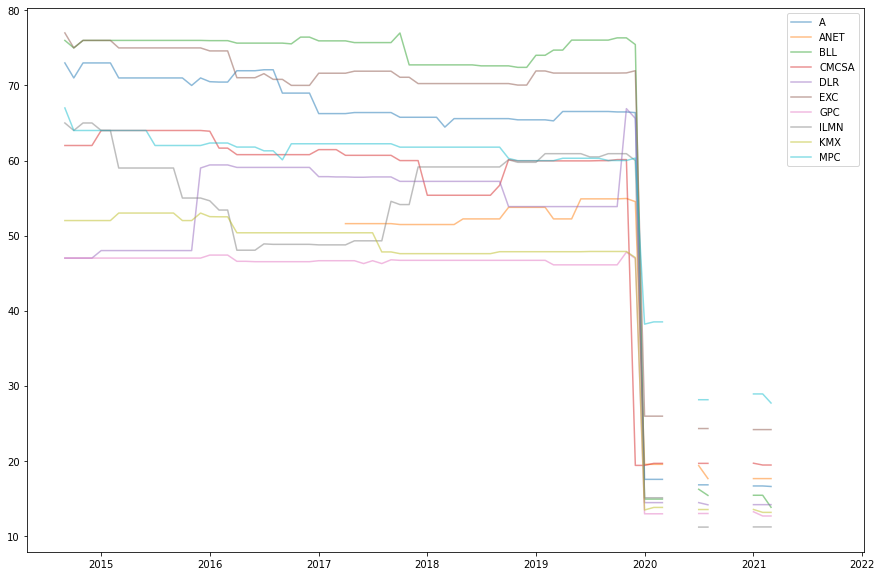

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for ticker in TICKERS[::30]:
    tmp = ESG_data.loc[ESG_data['ticker'] == ticker].sort_values(by = 'timestamp')
    out = plt.plot(tmp['timestamp'], tmp['esgScore'], alpha = 0.5)
    legend_ticks.append(ticker)

plt.legend(legend_ticks)

There is a clear structural break.

In [5]:
esg_series = ESG_data.copy()  #ESG_data.loc[ESG_data['ticker'] == 'BMY'].copy()
esg_series['timestamp'] = pd.to_datetime(esg_series['timestamp'])
min_date = np.min(ESG_data['timestamp'])
esg_series['date'] = esg_series['timestamp'].dt.date
min_date

Timestamp('2014-09-01 00:00:00')

In [6]:
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 
price_data = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")

price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
price_filtered = price_data.loc[price_data['timestamp'] >= min_date, price_data.columns]
price_filtered['date'] = price_filtered['timestamp'].dt.date

price_filtered['return'] = price_filtered.sort_values('date').groupby(['ticker']).adjclose.pct_change()


price_pivot = price_filtered[['ticker', 'return', 'date']].copy()
price_pivot['return'] = np.log(1 + price_pivot['return'])
price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')

In [7]:
start = datetime.date(2014,9,1)
end = datetime.date(2021,9,1)
[datetime.date(2014,9,1) + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
all_dates = pd.DataFrame({'date':[datetime.date(2014,9,1) + datetime.timedelta(days=x) for x in range(0, (end-start).days)]})
esg_series_all = pd.merge(all_dates, esg_series,how = 'left', on = 'date')
esg_series_all['ticker'].fillna(method='ffill', inplace=True)
# merge with asset_profiels to get sector
esg_series_all = pd.merge(esg_series_all, asset_profiles, how = 'left', on = 'ticker')
# sort for easier accounting
esg_series_all.sort_values(['sector', 'ticker', 'date'], inplace=True)
esg_series_all

,date,Unnamed: 0_x,timestamp,esgScore,governanceScore,environmentScore,socialScore,ticker,Unnamed: 0_y,address,city,state,zip,country,industry,sector,boardRisk,compensationRisk,shareHolderRightsRisk,overallRisk
12,2014-09-01,0.0,2014-09-01,68.00,81.0,57.0,71.00,ALB,0,4250 Congress Street,Charlotte,NC,28209,United States,Specialty Chemicals,Basic Materials,5.0,6.0,8.0,7.0
298,2014-10-01,1.0,2014-10-01,67.00,81.0,57.0,71.00,ALB,0,4250 Congress Street,Charlotte,NC,28209,United States,Specialty Chemicals,Basic Materials,5.0,6.0,8.0,7.0
587,2014-11-01,2.0,2014-11-01,67.00,79.0,57.0,71.00,ALB,0,4250 Congress Street,Charlotte,NC,28209,United States,Specialty Chemicals,Basic Materials,5.0,6.0,8.0,7.0
875,2014-12-01,3.0,2014-12-01,67.00,79.0,57.0,71.00,ALB,0,4250 Congress Street,Charlotte,NC,28209,United States,Specialty Chemicals,Basic Materials,5.0,6.0,8.0,7.0
1164,2015-01-01,4.0,2015-01-01,65.00,80.0,54.0,67.00,ALB,0,4250 Congress Street,Charlotte,NC,28209,United States,Specialty Chemicals,Basic Materials,5.0,6.0,8.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23714,2021-04-01,79.0,2021-04-01,NaN,NaN,NaN,NaN,LNT,0,4902 N. Biltmore Lane,Madison,WI,53718,United States,Utilities—Regulated Electric,Utilities,7.0,3.0,7.0,5.0
24017,2021-05-01,80.0,2021-05-01,27.99,6.3,14.3,7.38,LNT,0,4902 N. Biltmore Lane,Madison,WI,53718,United States,Utilities—Regulated Electric,Utilities,7.0,3.0,7.0,5.0
24319,2021-06-01,81.0,2021-06-01,NaN,NaN,NaN,NaN,LNT,0,4902 N. Biltmore Lane,Madison,WI,53718,United States,Utilities—Regulated Electric,Utilities,7.0,3.0,7.0,5.0
24602,2021-07-01,82.0,2021-07-01,NaN,NaN,NaN,NaN,LNT,0,4902 N. Biltmore Lane,Madison,WI,53718,United States,Utilities—Regulated Electric,Utilities,7.0,3.0,7.0,5.0


In [8]:
esg_pivot = esg_series_all[['ticker', 'esgScore', 'date']].copy()
esg_pivot = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker', dropna= False)
esg_pivot

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,MTB,PEAK,RE,SCHW,SJM,STZ,T,TECH,XOM,XRAY
date,,,,,,,,,,,,,,,,,,,,,
2014-09-01,73.0,73.0,48.0,61.0,64.0,55.0,64.0,72.0,70.0,66.0,...,50.0,NaN,45.0,50.0,61.0,54.0,66.0,NaN,66.0,57.0
2014-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Account for group membership

# Data for inference no shift

In [155]:
data_i_will_use = esg_pivot.copy().dropna(axis = 0, how = 'all' ).iloc[:60].copy().dropna(axis = 1, how = 'all' ).copy()
dates = np.array(data_i_will_use.index)

In [156]:
group_membership = []
for i in list(data_i_will_use.columns):
    sector = asset_profiles['sector'].loc[asset_profiles['ticker'] == i].iloc[0]
    if sector == 'Basic Materials':
        group_membership.append(0)
    elif sector == 'Communication Services':
        group_membership.append(1)
    elif sector == 'Consumer Cyclical':
        group_membership.append(2)
    elif sector == 'Consumer Defensive':
        group_membership.append(3)
    elif sector == 'Energy':
        group_membership.append(4)
    elif sector == 'Financial Services':
        group_membership.append(5)
    elif sector == 'Healthcare':
        group_membership.append(6)
    elif sector == 'Industrials':
        group_membership.append(7)
    elif sector == 'Real Estate':
        group_membership.append(8)
    elif sector == 'Technology':
        group_membership.append(9)
    elif sector == 'Utilities':
        group_membership.append(10)

group_membership = np.array(group_membership)

#  Data for inference shift median

In [9]:
data_median_shift = esg_pivot.dropna(axis = 0, how = 'all' ).dropna(axis = 1, how = 'all' ).copy() #.dropna(axis = 1 ).copy()
dates_median_shift = np.array(data_median_shift.index)

In [10]:
group_membership_median_shift = []
for i in list(data_median_shift.columns):
    sector = asset_profiles['sector'].loc[asset_profiles['ticker'] == i].iloc[0]
    if sector == 'Basic Materials':
        group_membership_median_shift.append(0)
    elif sector == 'Communication Services':
        group_membership_median_shift.append(1)
    elif sector == 'Consumer Cyclical':
        group_membership_median_shift.append(2)
    elif sector == 'Consumer Defensive':
        group_membership_median_shift.append(3)
    elif sector == 'Energy':
        group_membership_median_shift.append(4)
    elif sector == 'Financial Services':
        group_membership_median_shift.append(5)
    elif sector == 'Healthcare':
        group_membership_median_shift.append(6)
    elif sector == 'Industrials':
        group_membership_median_shift.append(7)
    elif sector == 'Real Estate':
        group_membership_median_shift.append(8)
    elif sector == 'Technology':
        group_membership_median_shift.append(9)
    elif sector == 'Utilities':
        group_membership_median_shift.append(10)

group_membership_median_shift = np.array(group_membership_median_shift)

In [11]:
y_shift = np.array([0] * data_median_shift.shape[1])
index = np.array(range(data_median_shift.shape[0]))
for i in range(len(data_median_shift.columns)):
    tmp = index[(data_median_shift.iloc[:,i].index > datetime.date(2019,9,1)) & (data_median_shift.iloc[:,i].diff() < -10)]
    if len(tmp) == 0:
        y_shift[i] = 999999
    else:
        y_shift[i] = tmp[0]

In [12]:
shifts = np.array([0] * data_median_shift.shape[1])
for i, company in enumerate(data_median_shift.columns):
    if y_shift[i] == 999999:
        shifts[i] = 0
    else:
        shifts[i] = np.nanmedian(data_median_shift.iloc[:y_shift[i], i]) - np.nanmedian(data_median_shift.iloc[y_shift[i]:, i])

In [13]:
#shift = np.nanmedian(data_median_shift.iloc[:63]) - np.nanmedian(data_median_shift.iloc[63:])
for i, company in enumerate(list(data_median_shift.columns)):
    if y_shift[i] == 999999:
        continue
    else:
        data_median_shift[company].iloc[y_shift[i]:] = data_median_shift[company].iloc[y_shift[i]:] + shifts[i]

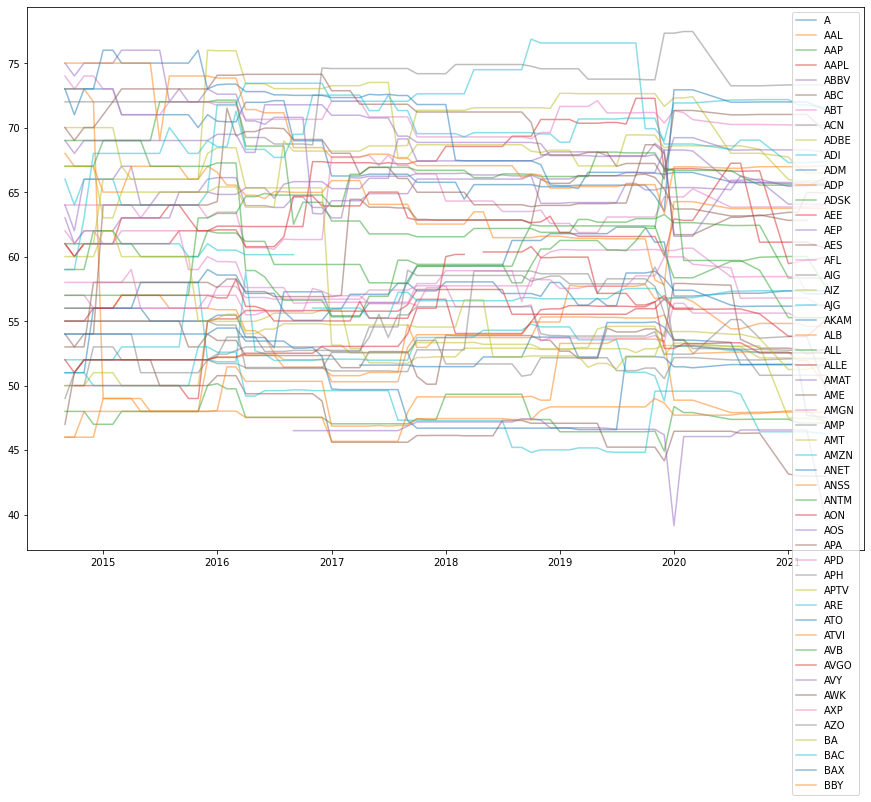

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for i in range(data_median_shift.shape[1]-230):
    out = plt.plot(dates_median_shift, data_median_shift.iloc[:,i], alpha = 0.5)
    legend_ticks.append(data_median_shift.columns[i])

plt.legend(legend_ticks)

# Univariate model

In [115]:
index = 0
y = np.array(data_i_will_use.iloc[:,index]).reshape((data_i_will_use.iloc[:,index].shape[0], 1))
dates = np.array(data_i_will_use.iloc[:,index].index)
V = np.identity(1)*10

A = np.nanmean(y, axis = 0)
B = np.array([-0.5])
F = np.array([[2]])
G = np.identity(1)
W = np.identity(1)
init_x = np.array([0.001] * (1))
init_c = np.identity((1)) * 10

In [116]:
dates

array([datetime.date(2014, 9, 1), datetime.date(2014, 10, 1),
       datetime.date(2014, 11, 1), datetime.date(2014, 12, 1),
       datetime.date(2015, 1, 1), datetime.date(2015, 2, 1),
       datetime.date(2015, 3, 1), datetime.date(2015, 4, 1),
       datetime.date(2015, 5, 1), datetime.date(2015, 6, 1),
       datetime.date(2015, 7, 1), datetime.date(2015, 8, 1),
       datetime.date(2015, 9, 1), datetime.date(2015, 10, 1),
       datetime.date(2015, 11, 1), datetime.date(2015, 12, 1),
       datetime.date(2016, 1, 1), datetime.date(2016, 2, 1),
       datetime.date(2016, 3, 1), datetime.date(2016, 4, 1),
       datetime.date(2016, 5, 1), datetime.date(2016, 6, 1),
       datetime.date(2016, 7, 1), datetime.date(2016, 8, 1),
       datetime.date(2016, 9, 1), datetime.date(2016, 10, 1),
       datetime.date(2016, 11, 1), datetime.date(2016, 12, 1),
       datetime.date(2017, 1, 1), datetime.date(2017, 2, 1),
       datetime.date(2017, 3, 1), datetime.date(2017, 4, 1),
       datetime

In [117]:
state, state_cov, state_one_step, state_cov_one_step, y_est = KalmanFilter(y, G, B, W, F, A, V, init_x, init_c)

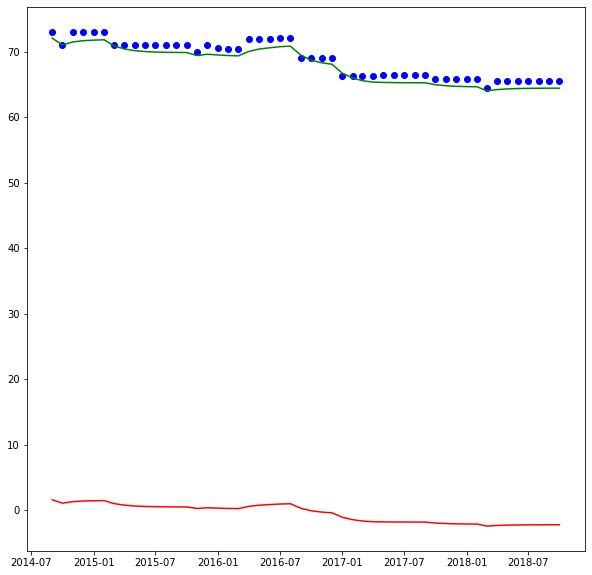

In [120]:
plt.figure(figsize=(10,10))
lines_smooth_all = plt.plot(dates, state[1:, 0], color='r')
lines_smooth_all = plt.plot(dates, y_est[:,0], color='g')
lines_smooth_all = plt.scatter(dates, y[:, 0], color='b')

# Multivariate model

In [12]:
# nr_groups = 11
# y = np.array(data_i_will_use)
# dates = list(data_i_will_use.index)
# V = np.identity(y.shape[1])

# A = np.nanmean(y, axis = 0)
# B = np.array([-1] * (nr_groups + 2))
# F = np.zeros((y.shape[1], (nr_groups + 2)))
# F[:,0] = 1/y.shape[0]
# F[:,-1] = 0.1
# F[range(F.shape[0]), group_membership + 1] = 1/nr_groups

# G = np.identity((nr_groups + 2))
# W = np.identity((nr_groups + 2))

# init_x = np.array([0.001] * (nr_groups + 2))
# init_c = np.identity((nr_groups + 2)) * 10

nr_groups = 11
y = np.array(data_i_will_use)
dates = list(data_i_will_use.index)
V = np.identity(y.shape[1])

A = np.nanmean(y, axis = 0)
B = np.array([-1] * (nr_groups + 1))
F = np.zeros((y.shape[1], (nr_groups + 1)))
F[:,0] = 1/y.shape[0]
F[:,-1] = 0.1
F[range(F.shape[0]), group_membership + 1] = 1/nr_groups

G = np.identity((nr_groups + 1))
W = np.identity((nr_groups + 1))

init_x = np.array([0.001] * (nr_groups + 1))
init_c = np.identity((nr_groups + 1)) * 10


In [140]:
state, state_cov, state_one_step, state_cov_one_step, y_est = KalmanFilter(y, G, B, W, F, A, V, init_x, init_c)

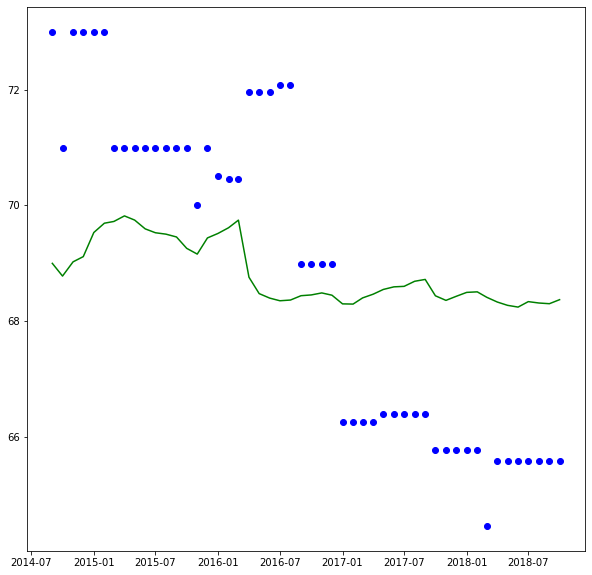

In [141]:
plt.figure(figsize=(10,10))
index = 0
#lines_smooth_all = plt.plot(dates, state[1:, index], color='r')
lines_smooth_all = plt.plot(dates, y_est[:,index], color='g')
lines_smooth_all = plt.scatter(dates, y[:, index], color='b')

In [ ]:
# same
# from pykalman import KalmanFilter as pykalmanfilter
# kf = pykalmanfilter(initial_state_mean= init_x, initial_state_covariance= init_c,
# transition_matrices = G, transition_offsets =  B, transition_covariance = np.identity((nr_groups + 2)),
# observation_matrices = F, 
# observation_offsets= A, 
# observation_covariance = np.identity((y.shape[1])))
# measurements = np.asarray(y)
# measurements[np.isnan(y)] = 50 #np.ma.masked

# (filtered_state_means, filtered_state_covariances) = kf.filter(y)


In [143]:
smooth_state, smooth_state_cov = KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, G, B, W)

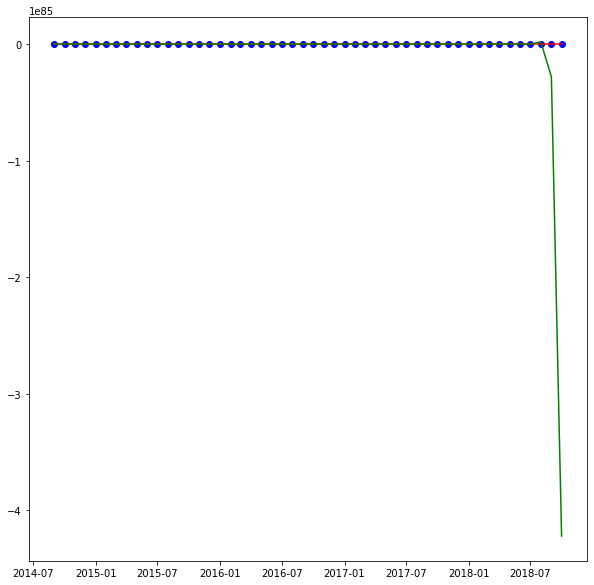

In [243]:
plt.figure(figsize=(10,10))
lines_smooth_all = plt.plot(dates,smooth_state[1:,0], color='r')
lines_smooth_all = plt.plot(dates, y_est[:,0], color='g')
lines_smooth_all = plt.scatter(dates, y[:,0], color='b')

Gibbs sampler for

$$ y_t = \alpha + \beta \kappa_t + v_t $$
$$\kappa_t = \kappa_{t-1} + \eta + w_t $$

with constraints:

$$\sum_t \kappa_t = 0$$

using $\kappa_t = \tilde{\kappa}_t - (1/T) \sum_t \tilde{\kappa}_t$

In [ ]:
plt.figure(figsize=(10,10))
lines_smooth_all = plt.plot(range(G_vec.shape[0]),G_vec[:,0], color='r')
plt.ylim([-0.002, 0.002])
plt.xlim([1, 2000])

# Local level, group drift

In [185]:
nr_groups = 11
y = np.array(data_i_will_use)
n_stock = y.shape[1]
dates = list(data_i_will_use.index)
V = np.identity(y.shape[1])

A = np.nanmean(y, axis = 0)
B = np.array([1] *n_stock+ [-0.1] * nr_groups + [-0.01]  * 1)
F = np.zeros((y.shape[1], (n_stock + nr_groups + 1)))

# F[:, :n_stock] = np.identity(n_stock)
# F[:,-1] = 0.1
# F[range(F.shape[0]), n_stock + group_membership] = 1/nr_groups

F[range(n_stock), range(n_stock)] = B[:n_stock]
F[:,-1] = B[-1]
#F[range(F.shape[0]), n_stock + group_membership] = B[n_stock:(n_stock + nr_groups)]
F[range(F.shape[0]), group_membership + n_stock] = 1
F[:,n_stock:(nr_groups + n_stock)]  = np.multiply(F[:,n_stock:(nr_groups + n_stock)], B[y.shape[1]:(B.shape[0] - 1)])

G = np.identity((n_stock + nr_groups + 1))
W = np.identity((n_stock + nr_groups + 1))

init_x = np.array([1] *n_stock+ [1/nr_groups] * nr_groups + [0.1]  * 1)
init_c = np.identity((n_stock + nr_groups + 1)) * 4


In [186]:
state, state_cov, state_one_step, state_cov_one_step, y_est = Gibbs.KalmanFilter(y, G, B, W, F, A, V, init_x, init_c)

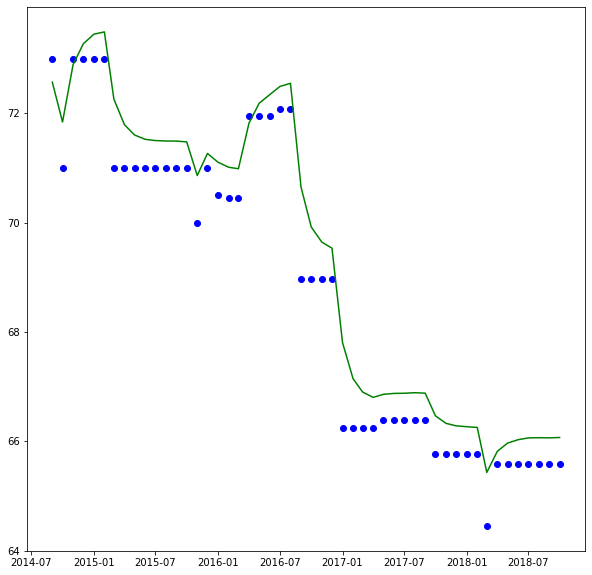

In [178]:
plt.figure(figsize=(10,10))
index = 0
#lines_smooth_all = plt.plot(dates, state[1:, index], color='r')
lines_smooth_all = plt.plot(dates, y_est[:,index], color='g')
lines_smooth_all = plt.scatter(dates, y[:, index], color='b')

In [190]:
smooth_state, smooth_state_cov = Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, G, B, W)

In [191]:
y_est_smooth = y_est.copy()
for i in range(y_est_smooth.shape[0]):
    y_est_smooth[i] = np.dot(F, smooth_state[i+1]) + A
    

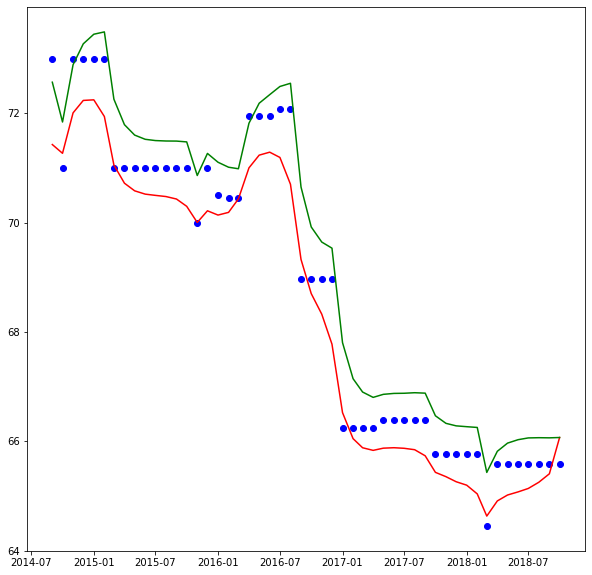

In [192]:
plt.figure(figsize=(10,10))
lines_smooth_all = plt.plot(dates,y_est_smooth[:,0], color='r')
lines_smooth_all = plt.plot(dates, y_est[:,0], color='g')
lines_smooth_all = plt.scatter(dates, y[:,0], color='b')

Gibbs for this model

In [457]:
N = 200
y  = np.array(data_i_will_use)

beta_mean = np.array([0] * (y.shape[1] + nr_groups + 1))
beta_var = np.array([1] * (y.shape[1] + nr_groups + 1))

alpha_mean = np.array([70] * y.shape[1])
alpha_var = np.array([10] * y.shape[1]) 

eta_mean = np.array([0] *  (n_stock +  nr_groups + 1))
eta_var = np.array([10] *  (n_stock +  nr_groups + 1))

v_alpha = 2 
v_beta = 2 

w_alpha = np.array([2] *  (n_stock + nr_groups + 1))
w_beta = np.array([2] *  (n_stock + nr_groups + 1))

beta_init = np.array([1] * y.shape[1] + [0.1] * nr_groups +  [0.1])
alpha_init = np.nanmean(y, axis = 0)

eta_init = np.array([0] * y.shape[1] + [0.1] * nr_groups +  [0.1])
w_init = np.ones(y.shape[1] + nr_groups + 1) 
v_init = 10

init_x = np.array([1] * (n_stock + nr_groups + 1))
init_c = np.identity((n_stock + nr_groups + 1)) * 2

sector_membership = group_membership

# N = 200
# y  = np.array(data_i_will_use)

# beta_mean = np.array([0] * (y.shape[1] + nr_groups))
# beta_var = np.array([1] * (y.shape[1] + nr_groups))

# alpha_mean = np.array([70] * y.shape[1])
# alpha_var = np.array([10] * y.shape[1]) 

# eta_mean = np.array([0] *  (n_stock +  nr_groups))
# eta_var = np.array([10] *  (n_stock +  nr_groups))

# v_alpha = 2 
# v_beta = 2 

# w_alpha = np.array([2] *  (n_stock + nr_groups ))
# w_beta = np.array([2] *  (n_stock + nr_groups ))

# beta_init = np.array([1] * y.shape[1] + [0.1] * nr_groups )
# alpha_init = np.nanmean(y, axis = 0)

# eta_init = np.array([0] * y.shape[1] + [0.1] * nr_groups)
# w_init = np.ones(y.shape[1] + nr_groups ) 
# v_init = 10

# init_x = np.array([1] * (n_stock + nr_groups))
# init_c = np.identity((n_stock + nr_groups)) * 2

# sector_membership = group_membership


In [458]:
#def Gibbs(N, y, beta_mean, beta_var, alpha_mean, alpha_var, eta_mean, eta_var, v_alpha, v_beta, w_alpha, w_beta, beta_init, alpha_init, eta_init, w_init, v_init, init_x, init_c, group_membership):
    # """
    # Calculate Kalman Smoother
    # y_t = Fx_t + A
    # x_t = Gx_{t-1} + B 
    # """


n_stock = y.shape[1]
B_vec = np.zeros((N+1,init_x.shape[0]))
B_vec[0] = eta_init
w = np.zeros((N+1,init_x.shape[0]))
w[0] = w_init

# F_vec = np.zeros((N+1,F.shape[0], F.shape[1]))
beta_vec = np.zeros((N+1,beta_init.shape[0]))
beta_vec[0] = beta_init
A_vec = np.zeros((N+1,alpha_mean.shape[0]))
A_vec[0] = alpha_init
v = np.zeros((N+1, 1))
v[0] = v_init

G = np.identity(init_x.shape[0])
nr_groups = len(np.unique(group_membership))
F = np.zeros((y.shape[1], (n_stock + nr_groups + 1)))
#F = np.zeros((y.shape[1], (n_stock + nr_groups )))

# constraint
beta_vec[0, :n_stock] = beta_vec[0, :n_stock]/np.sum(beta_vec[0, :n_stock])
beta_vec[0, n_stock:(n_stock + nr_groups)] = beta_vec[0, n_stock:(n_stock + nr_groups)]/np.sum(beta_vec[0, n_stock:(n_stock + nr_groups)])

init_x = init_x - np.mean(init_x, axis=0)

for i in range(1,N):
    print( f'{i} of {N}')

    
    F[range(n_stock), range(n_stock)] = beta_vec[i-1,:n_stock]
    F[:,-1] = beta_vec[i-1,-1]
    F[range(F.shape[0]), group_membership + n_stock] = 1
    F[:,n_stock:(nr_groups + n_stock)]  = np.multiply(F[:,n_stock:(nr_groups + n_stock )], beta_vec[i-1, n_stock:(nr_groups + n_stock )])
    
    try:    
        state, state_cov, state_one_step, state_cov_one_step, y_est = KalmanFilter(y, G, B_vec[i-1], np.diag(w[i-1]), F, A_vec[i-1], v[i-1] * np.identity(A_vec[i-1].shape[0]), init_x, init_c)
        smooth_state, smooth_state_cov = KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, G, B_vec[i], np.diag(w[i-1]))
    except np.linalg.LinAlgError:
        print('linkalg error')

    smooth_state_new =  smooth_state - np.mean(smooth_state, axis=0)
    # smooth_state_new = smooth_state

    # sample beta_i
    for j in range(y.shape[1]):
        var = 1 / ((np.sum(smooth_state_new[1:,j] ** 2) / v[i-1]) + (1 / beta_var[j]))
        tmp1 = y[:,j]*smooth_state_new[1:,j]
        tmp2 = A_vec[i-1, j]*smooth_state_new[1:,j] 
        tmp3 = beta_vec[i-1, n_stock + group_membership[j]]*smooth_state_new[1:, n_stock + group_membership[j]]*smooth_state_new[1:,j]
        tmp4 = beta_vec[i-1,-1]*smooth_state_new[1:,-1]*smooth_state_new[1:,j]

        avg = ((beta_mean[j]/beta_var[j]) + (np.nansum(tmp1 - tmp2 - tmp3 -  tmp4))/v[i-1]) * var
        #avg = ((beta_mean[j]/beta_var[j]) + (np.nansum(tmp1 - tmp2 - tmp3))/v[i-1]) * var
        beta_vec[i,j] = np.random.normal(avg, np.sqrt(var))

    # sample beta_g_i
    for j in range(nr_groups):
        var = 1 / ((np.sum(smooth_state_new[1:,n_stock + j] ** 2) / v[i-1]) + (1 / beta_var[n_stock + j]))
        avg = 0
        for k in range(y.shape[1]):
            if group_membership[k] != j:
                continue
            tmp1 = y[:, k]*smooth_state_new[1:,n_stock + j]
            tmp2 = A_vec[i-1, k]*smooth_state_new[1:,n_stock + j]
            tmp3 = beta_vec[i, k]*smooth_state_new[1:,n_stock + j]*smooth_state_new[1:,k]
            tmp4 = beta_vec[i-1, -1]*smooth_state_new[1:,n_stock + j]*smooth_state_new[1:,-1]
            avg += np.nansum(tmp1 - tmp2 - tmp3 - tmp4 )/v[i-1]
            # avg += np.nansum(tmp1 - tmp2 - tmp3 )/v[i-1]
        avg += beta_mean[y.shape[1] + j]/beta_var[y.shape[1] + j]
        avg *= var

        beta_vec[i,n_stock + j] = np.random.normal(avg, np.sqrt(var))

    
    # sample beta_m
    var = 1 / ((np.sum(smooth_state_new[1:,-1] ** 2) / v[i-1]) + (1 / beta_var[-1]))
    avg = 0
    for k in range(y.shape[1]):
        tmp1 = y[:, k]*smooth_state_new[1:,-1]
        tmp2 = A_vec[i-1, k]*smooth_state_new[1:,-1]
        tmp3 = beta_vec[i, k]*smooth_state_new[1:,0]*smooth_state_new[1:,-1]
        tmp4 = beta_vec[i, n_stock + group_membership[k]]*smooth_state_new[1:, n_stock + group_membership[k]]*smooth_state_new[1:,-1]
        avg += np.nansum(tmp1 - tmp2 - tmp3 - tmp4 )/v[i-1]
    avg += beta_mean[-1]/beta_var[-1]
    avg *= var

    beta_vec[i,-1] = np.random.normal(avg, np.sqrt(var))

    # constraint
    beta_vec[i, :n_stock] = beta_vec[i, :n_stock]/np.sum(beta_vec[i, :n_stock])
    beta_vec[i, n_stock:(n_stock + nr_groups)] = beta_vec[i, n_stock:(n_stock + nr_groups)]/np.sum(beta_vec[i, n_stock:(n_stock + nr_groups)])

    # sample alpha
    for j in range(A_vec.shape[1]):
        var = 1 / ((n_stock / v[i-1]) + (1 / alpha_var[j]))
        avg = 0
        avg += np.nansum(y[:, j] - beta_vec[i,j]*smooth_state_new[1:, j] - beta_vec[i,n_stock + group_membership[k]]*smooth_state_new[1:, n_stock + group_membership[k]] - beta_vec[i,-1]*smooth_state_new[1:, -1] )/v[i-1]
        #avg += np.nansum(y[:, j] - beta_vec[i,j]*smooth_state_new[1:, j] - beta_vec[i,n_stock + group_membership[k]]*smooth_state_new[1:, n_stock + group_membership[k]] )/v[i-1]
        avg += alpha_mean[k]/alpha_var[k]
        avg *= var
        A_vec[i,j] = np.random.normal(avg, np.sqrt(var))


    # sample variance of observation
    alpha = (n_stock/2) + v_alpha
    beta = 0
    for j in range(y.shape[1]):
        beta += np.nansum((y[:,j] - A_vec[i,j] - beta_vec[i,j]*smooth_state_new[1:, j] - beta_vec[i,n_stock + group_membership[k]]*smooth_state_new[1:, n_stock + group_membership[k]] - beta_vec[i,-1]*smooth_state_new[1:, -1]  ) ** 2)
        #beta += np.nansum((y[:,j] - A_vec[i,j] - beta_vec[i,j]*smooth_state_new[1:, j] - beta_vec[i,n_stock + group_membership[k]]*smooth_state_new[1:, n_stock + group_membership[k]]   ) ** 2)
    beta += v_beta
    v[i] = 1 / np.random.gamma(shape = alpha, scale = beta)

    
    # sample eta
    for j in range(n_stock, smooth_state_new.shape[1]):
        var = 1 / ((n_stock / w[i-1,j]) + (1 / eta_var[j]))
        avg = ((np.sum(smooth_state_new[1:, j] - smooth_state_new[:(smooth_state_new.shape[0] - 1), j]) / w[i-1,j]) + (eta_mean[j]/eta_var[j])) * var
        B_vec[i,j] = np.random.normal(avg, np.sqrt(var))

    
    # sample state variance
    for j in range(smooth_state_new.shape[1]):
        alpha = y.shape[1]/2 + w_alpha[j]
        beta = np.nansum((smooth_state_new[1:] - smooth_state_new[:(smooth_state_new.shape[0]-1)] - B_vec[i-1, j]) ** 2) + w_beta[j]
        w[i,j] = 1 / np.random.gamma(shape = alpha, scale = beta)
    


1 of 200
2 of 200
3 of 200
linkalg error
4 of 200
linkalg error
5 of 200
linkalg error
6 of 200
linkalg error
7 of 200
linkalg error
8 of 200
linkalg error
9 of 200
linkalg error
10 of 200
linkalg error
11 of 200
linkalg error
12 of 200
linkalg error
13 of 200
linkalg error
14 of 200
linkalg error
15 of 200
linkalg error
16 of 200
linkalg error
17 of 200
linkalg error
18 of 200
linkalg error
19 of 200
linkalg error
20 of 200
linkalg error
21 of 200
linkalg error
22 of 200
linkalg error
23 of 200
linkalg error
24 of 200
linkalg error
25 of 200
linkalg error
26 of 200
linkalg error
27 of 200
linkalg error
28 of 200
linkalg error
29 of 200
linkalg error
30 of 200
linkalg error
31 of 200
linkalg error
32 of 200
linkalg error
33 of 200
linkalg error
34 of 200
linkalg error
35 of 200
linkalg error
36 of 200
linkalg error
37 of 200
linkalg error
38 of 200
linkalg error
39 of 200
linkalg error
40 of 200


C:\Users\ragna\AppData\Local\Temp/ipykernel_14860/3806476969.py:60: RuntimeWarning: overflow encountered in true_divide
  avg = ((beta_mean[j]/beta_var[j]) + (np.nansum(tmp1 - tmp2 - tmp3 -  tmp4))/v[i-1]) * var
c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


KeyboardInterrupt: 

(1.0, 200.0)

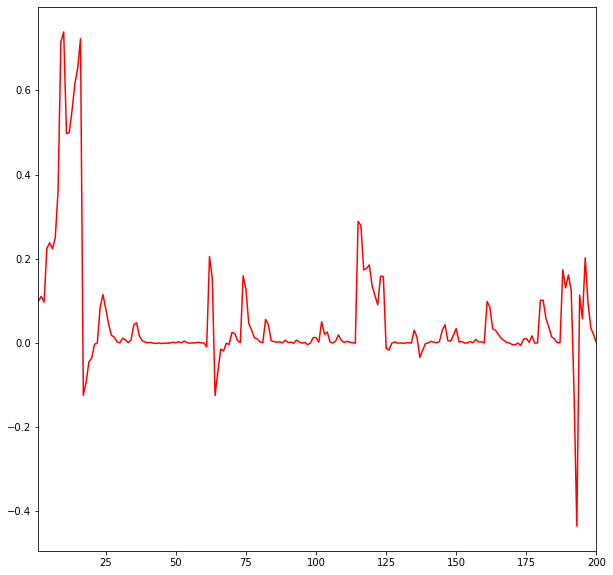

In [450]:
plt.figure(figsize=(10,10))
lines_smooth_all = plt.plot(range(A_vec.shape[0]),beta_vec[:,-2], color='r')
#plt.ylim([-0.002, 0.002])
plt.xlim([1, 200])

In [351]:
state

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.46523953e+05,  1.37741577e+05, -6.20121615e+05, ...,
         3.56059104e+05,  6.28904032e+01,  4.55854350e+04],
       [ 2.43637098e+05,  2.53051532e+05, -1.09174381e+06, ...,
         6.38486358e+05,  6.24444943e+01,  8.08341836e+04],
       ...,
       [ 9.03993318e+05, -3.28385263e+05, -3.95511401e+06, ...,
         3.28083773e+06,  6.47984168e+01,  3.78807352e+05],
       [ 9.10517847e+05, -3.17852536e+05, -3.96219855e+06, ...,
         3.30291058e+06,  6.48347543e+01,  3.81050315e+05],
       [ 9.16556304e+05, -3.07987516e+05, -3.96578089e+06, ...,
         3.32447905e+06,  6.48860879e+01,  3.83283195e+05]])

# local level with drift only

In [193]:
y = np.array(data_i_will_use)
w_ll, v_ll, beta_vec_ll, A_vec_ll, B_vec_ll, states_ll = Gibbs.local_level_drift(200, y)

1 of 200
2 of 200
3 of 200
4 of 200
5 of 200
6 of 200
7 of 200
8 of 200
9 of 200
10 of 200
11 of 200
12 of 200
13 of 200
14 of 200
15 of 200
16 of 200
17 of 200
18 of 200
19 of 200
20 of 200
21 of 200
22 of 200
23 of 200
24 of 200
25 of 200
26 of 200
27 of 200
28 of 200
29 of 200
30 of 200
31 of 200
32 of 200
33 of 200
34 of 200
35 of 200
36 of 200
37 of 200
38 of 200
39 of 200
40 of 200
41 of 200
42 of 200
43 of 200
44 of 200
45 of 200
46 of 200
47 of 200
48 of 200
49 of 200
50 of 200
51 of 200
52 of 200
53 of 200
54 of 200
55 of 200
56 of 200
57 of 200
58 of 200
59 of 200
60 of 200
61 of 200
62 of 200
63 of 200
64 of 200
65 of 200
66 of 200
67 of 200
68 of 200
69 of 200
70 of 200
71 of 200
72 of 200
73 of 200
74 of 200
75 of 200
76 of 200
77 of 200
78 of 200
79 of 200
80 of 200
81 of 200
82 of 200
83 of 200
84 of 200
85 of 200
86 of 200
87 of 200
88 of 200
89 of 200
90 of 200
91 of 200
92 of 200
93 of 200
94 of 200
95 of 200
96 of 200
97 of 200
98 of 200
99 of 200
100 of 200
101 of 2

In [115]:
states_ll[-1][0].shape

(260,)

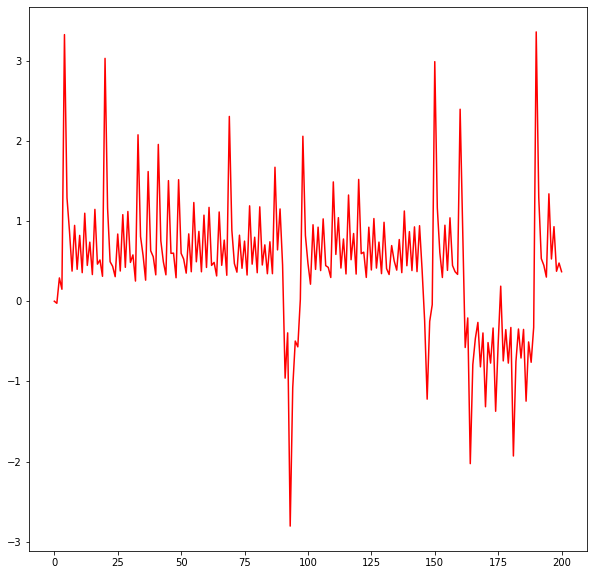

In [194]:
plt.figure(figsize=(10,10))
lines_smooth_all = plt.plot(range(B_vec_ll.shape[0]),B_vec_ll[:,0], color='r')
#plt.ylim([-0.005, 0.005])
#plt.xlim([60, 199])

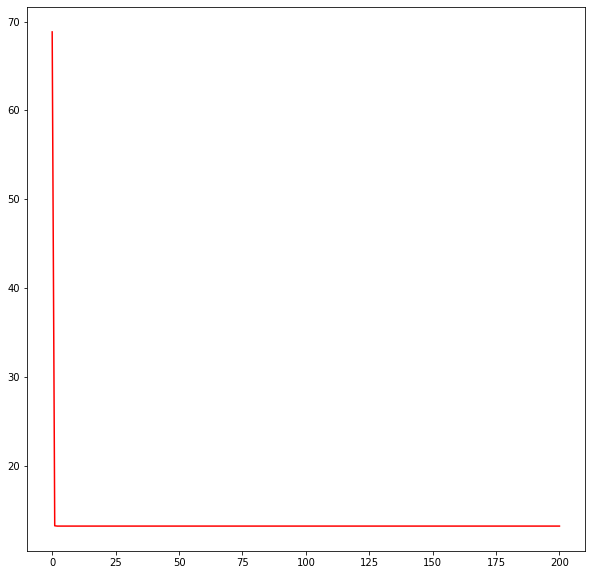

In [195]:
plt.figure(figsize=(10,10))
lines_smooth_all = plt.plot(range(A_vec_ll.shape[0]),A_vec_ll[:,0], color='r')
#plt.ylim([13.15, 13.25])
#plt.xlim([4, 500])

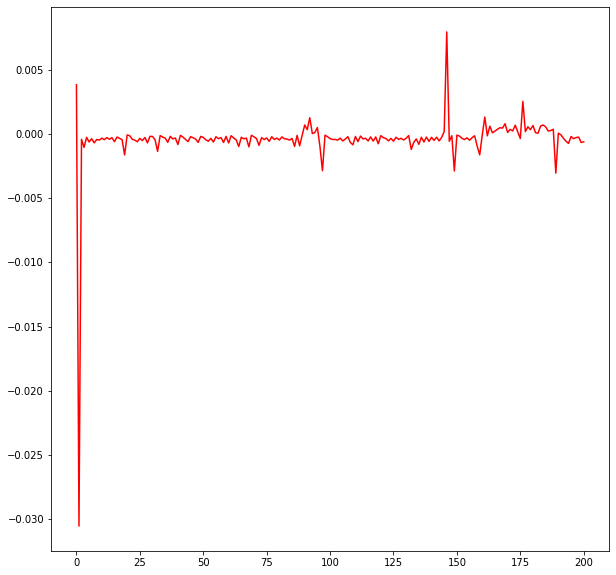

In [197]:
plt.figure(figsize=(10,10))
lines_smooth_all = plt.plot(range(beta_vec_ll.shape[0]),beta_vec_ll[:,0], color='r')
#plt.ylim([13.15, 13.25])
#plt.xlim([4, 500])

## Fit local level with drift

For a parameter estimation we will use the median and a burn-in of 100

In [200]:
A_ll_best = np.median(A_vec_ll[100:,],axis=0)
beta_ll_best = np.median(beta_vec_ll[100:], axis = 0)
eta_ll_best = np.median(B_vec_ll[100:], axis = 0)
w_ll_best  = np.median(w_ll[100:], axis = 0)
v_ll_best  = np.median(v_ll[100:], axis = 0)

# Kalman parameters
n_stock = y.shape[1]
F = np.zeros((n_stock,n_stock))
F[range(n_stock), range(n_stock)] = beta_ll_best[:n_stock]

init_x = states_ll[-1][0]
init_c = np.identity((n_stock )) * 2
G = np.identity(init_x.shape[0])

Use the "best" parameter for  Kalman smoothing

In [201]:
state, state_cov, state_one_step, state_cov_one_step, y_est = KalmanFilter(y, G, eta_ll_best, np.diag(w_ll_best), F, A_ll_best, v_ll_best * np.identity(A_ll_best.shape[0]), init_x, init_c)
smooth_state, smooth_state_cov = KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, G, eta_ll_best, np.diag(w_ll_best))

In [202]:
y_est_smooth = np.zeros((y.shape[0], y.shape[1]))
for i in range(y.shape[0]):
    y_est_smooth[i] = np.dot(F, smooth_state[i+1]) + A_ll_best

In [203]:
smooth_state

array([[-216979.3744814 , -462517.90287262,   21075.0124717 , ...,
           9837.69382555,  608401.42617904, -479278.09944165],
       [-216979.51480891, -462518.0296624 ,   21080.14838191, ...,
           9838.12009799,  608401.8801866 , -479278.30803799],
       [-216978.60752172, -462517.62421185,   21080.50272912, ...,
           9838.54637043,  608402.00894417, -479278.22229673],
       ...,
       [-216911.41825645, -462503.53878215,   21112.12639682, ...,
           9858.15490471,  608405.39898887, -479268.22359151],
       [-216910.53517183, -462503.38978308,   21112.55247507, ...,
           9878.86575815,  608405.5304834 , -479268.10021484],
       [-216909.70641593, -462503.23682756,   21112.82065076, ...,
           9879.30182152,  608405.66460805, -479267.99057449]])

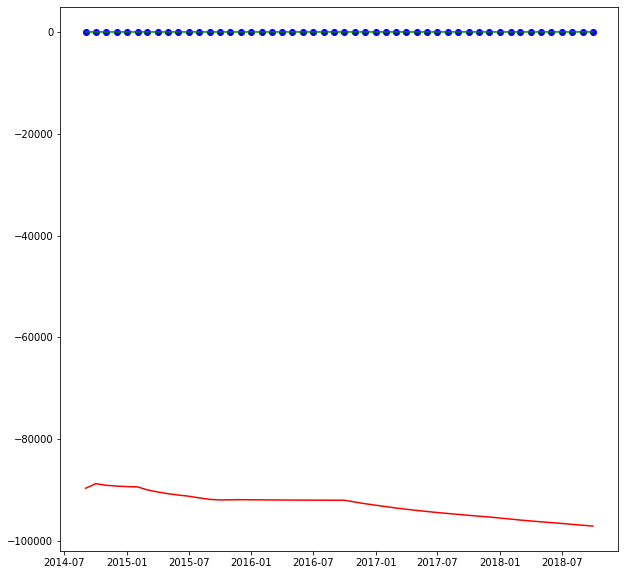

In [204]:
plt.figure(figsize=(10,10))
index = 3
lines_smooth_all = plt.plot(dates, state[1:, index], color='r')
lines_smooth_all = plt.plot(dates, y_est[:,index], color='g')
lines_smooth_all = plt.scatter(dates, y[:, index], color='b')

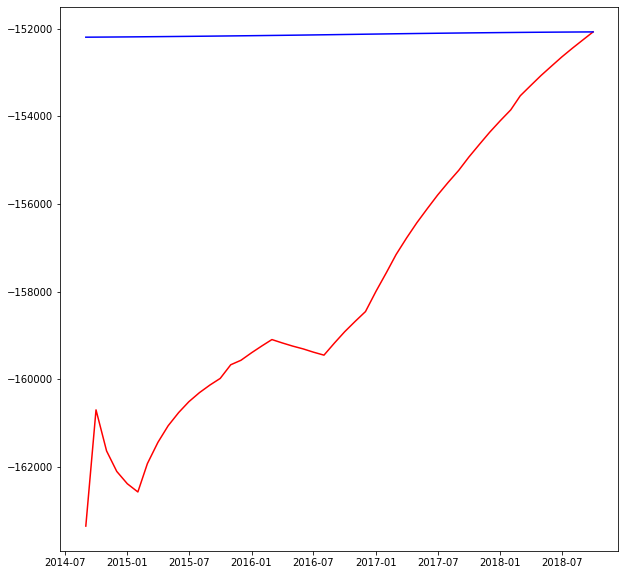

In [162]:
plt.figure(figsize=(10,10))
index = 0
lines_smooth_all = plt.plot(dates, state[1:, index], color='r')
lines_smooth_all = plt.plot(dates, smooth_state[1:, index], color='b')
#lines_smooth_all = plt.plot(dates, y_est[:,index], color='g')
#lines_smooth_all = plt.scatter(dates, y[:, index], color='b')

villur
smooth_state, á að vera smooth_state_new
sample eta for j in range(n_stock): ekki nstock, nstock + nr_groups
sum

# Local Level, constraint

In [164]:
y = np.array(data_i_will_use)
w_ll_c, v_ll_c, beta_vec_ll_c, A_vec_ll_c, B_vec_ll_c, states_ll_c = Gibbs.local_level(40, y, True)

1 of 40
2 of 40
3 of 40


KeyboardInterrupt: 

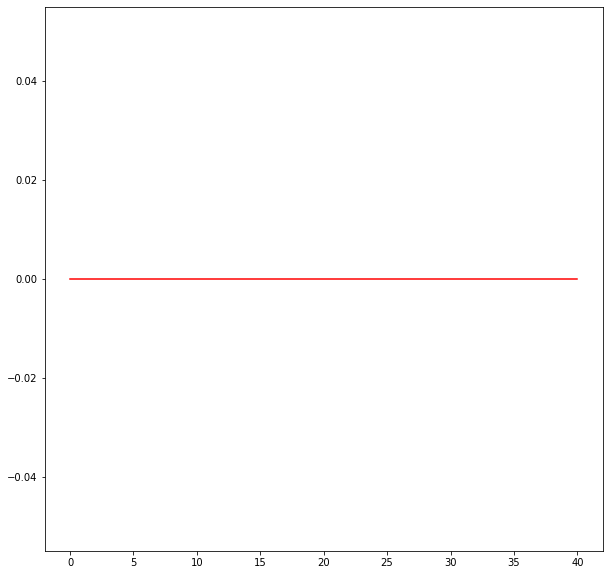

In [68]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(B_vec_ll.shape[0]),B_vec_ll[:,0], color='r')

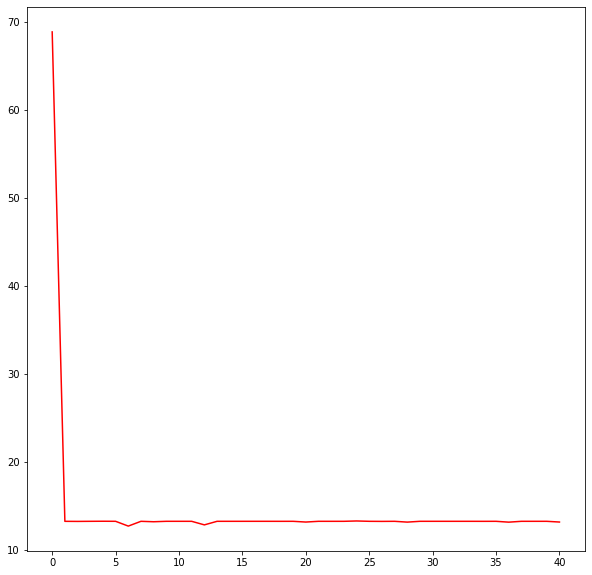

In [69]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(A_vec_ll.shape[0]),A_vec_ll[:,0], color='r')

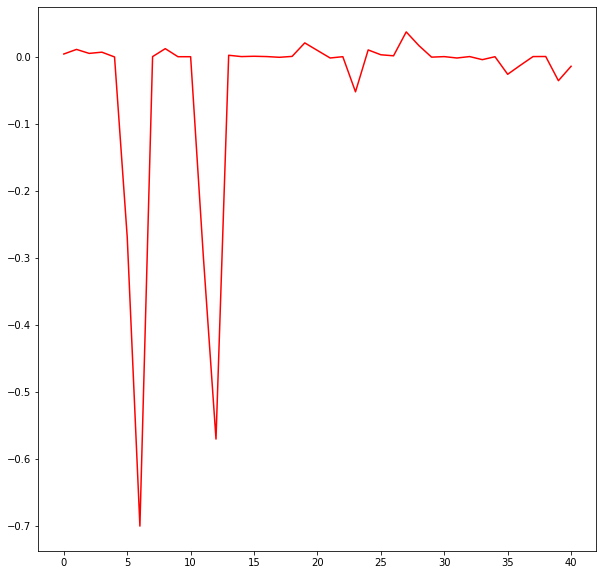

In [70]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(beta_vec_ll.shape[0]),beta_vec_ll[:,0], color='r')

In [90]:
burn_in = 30
A_ll_best = np.median(A_vec_ll[burn_in:,],axis=0)
beta_ll_best = np.median(beta_vec_ll[burn_in:], axis = 0)
eta_ll_best = np.median(B_vec_ll[burn_in:], axis = 0)
w_ll_best  = np.median(w_ll[burn_in:], axis = 0)
v_ll_best  = np.median(v_ll[burn_in:], axis = 0)

# Kalman parameters
n_stock = y.shape[1]
F = np.zeros((n_stock,n_stock))
F[range(n_stock), range(n_stock)] = beta_ll_best[:n_stock]

init_x = np.zeros(n_stock)
init_c = np.identity((n_stock )) * 2
G = np.identity(init_x.shape[0])

state, state_cov, state_one_step, state_cov_one_step, y_est = Gibbs.KalmanFilter(y, G, eta_ll_best, np.diag(w_ll_best), F, A_ll_best, v_ll_best * np.identity(A_ll_best.shape[0]), init_x, init_c)
smooth_state, smooth_state_cov = Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, G, eta_ll_best, np.diag(w_ll_best))

smooth_state = smooth_state - np.mean(smooth_state, axis = 0)
state = state - np.mean(state, axis = 0)

y_est_smooth = np.zeros((y.shape[0], y.shape[1]))
for i in range(y.shape[0]):
    y_est_smooth[i] = np.dot(F, smooth_state[i+1]) + A_ll_best
    y_est[i] = np.dot(F, state[i+1]) + A_ll_best


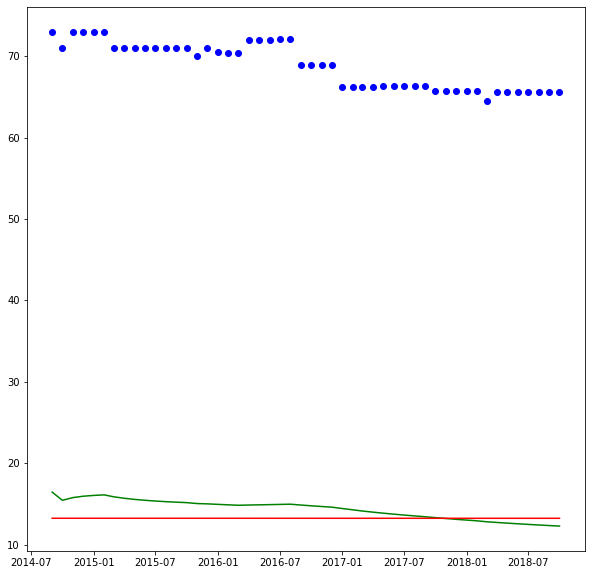

In [91]:
plt.figure(figsize=(10,10))
index = 0
#lines_smooth_all = plt.plot(dates, state[1:, index], color='r')
lines_smooth_all = plt.plot(dates, y_est[:,index], color='g')
lines_smooth_all = plt.plot(dates, y_est_smooth[:,index], color='r')
lines_smooth_all = plt.scatter(dates, y[:, index], color='b')

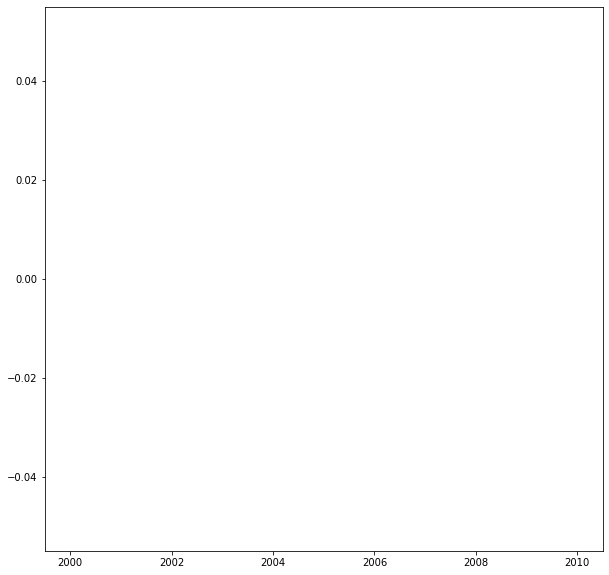

In [74]:
plt.figure(figsize=(10,10))
lines_smooth_all = plt.plot(dates, state[1:, index], color='r')
lines_smooth_all = plt.plot(dates, smooth_state[1:, index], color='b')

# Local level

In [209]:
y = np.array(data_i_will_use)
w_ll, v_ll, beta_vec_ll, A_vec_ll, B_vec_ll, states_ll = Gibbs.local_level(200, y, False)

1 of 200


KeyboardInterrupt: 

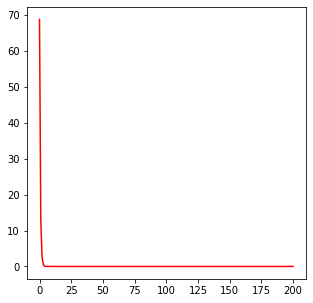

In [167]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(A_vec_ll.shape[0]),A_vec_ll[:,0], color='r')

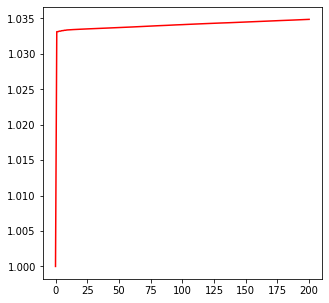

In [168]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(beta_vec_ll.shape[0]),beta_vec_ll[:,0], color='r')

In [169]:
burn_in = 30
A_ll_best = np.median(A_vec_ll[burn_in:,],axis=0)
beta_ll_best = np.median(beta_vec_ll[burn_in:], axis = 0)
eta_ll_best = np.median(B_vec_ll[burn_in:], axis = 0)
w_ll_best  = np.median(w_ll[burn_in:], axis = 0)
v_ll_best  = np.median(v_ll[burn_in:], axis = 0)

# Kalman parameters
n_stock = y.shape[1]
F = np.zeros((n_stock,n_stock))
F[range(n_stock), range(n_stock)] = beta_ll_best[:n_stock]

init_x = np.zeros(n_stock)
init_c = np.identity((n_stock )) * 2
G = np.identity(init_x.shape[0])

state, state_cov, state_one_step, state_cov_one_step, y_est = Gibbs.KalmanFilter(y, G, eta_ll_best, np.diag(w_ll_best), F, A_ll_best, v_ll_best * np.identity(A_ll_best.shape[0]), init_x, init_c)
smooth_state, smooth_state_cov = Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, G, eta_ll_best, np.diag(w_ll_best))

y_est_smooth = np.zeros((y.shape[0], y.shape[1]))
for i in range(y.shape[0]):
    y_est_smooth[i] = np.dot(F, smooth_state[i+1]) + A_ll_best
    y_est[i] = np.dot(F, state[i+1]) + A_ll_best


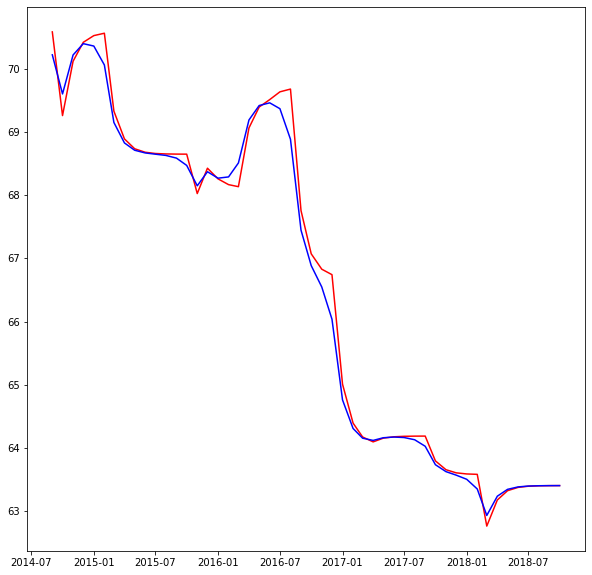

In [170]:
plt.figure(figsize=(10,10))
lines_smooth_all = plt.plot(dates, state[1:, index], color='r')
lines_smooth_all = plt.plot(dates, smooth_state[1:, index], color='b')

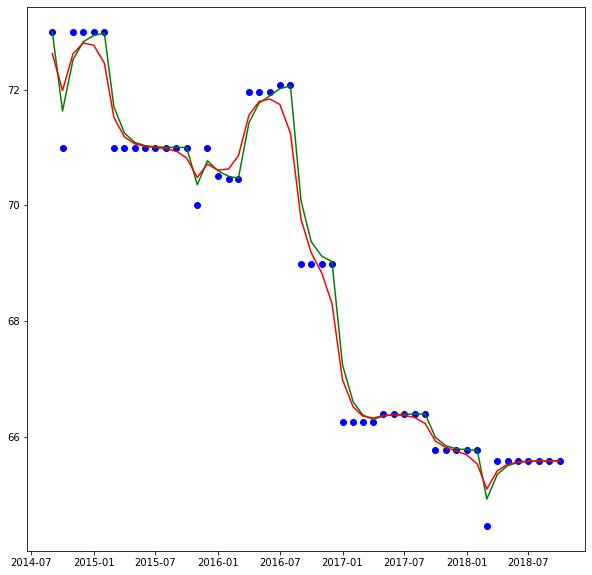

In [171]:
plt.figure(figsize=(10,10))
index = 0
#lines_smooth_all = plt.plot(dates, state[1:, index], color='r')
lines_smooth_all = plt.plot(dates, y_est[:,index], color='g')
lines_smooth_all = plt.plot(dates, y_est_smooth[:,index], color='r')
lines_smooth_all = plt.scatter(dates, y[:, index], color='b')

# LC+sector ESG

In [164]:
importlib.reload(sys.modules['Gibbs'])
y = np.array(data_median_shift)
n_stock = y.shape[0]
nr_groups = len(np.unique(group_membership_median_shift))
w_lc_s, v_lc_s, beta_vec_lc_s, A_vec_lc_s, B_vec_lc_s, states_lc_s = Gibbs.lc_sector(2000, y, group_membership_median_shift)

T 74, n_stock 282, n_groups 11
1 of 2000 
0.0 vs 0.0
2 of 2000 
0.0 vs 0.0
3 of 2000 
0.0 vs 0.0
4 of 2000 


C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:261: RuntimeWarning: overflow encountered in power
  tmp1 = y[:,j]**smooth_state_new[:,1 + group_membership[j]]
C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:262: RuntimeWarning: overflow encountered in power
  tmp2 = A_vec[i-1, j]**smooth_state_new[:,1 + group_membership[j]]
C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:265: RuntimeWarning: invalid value encountered in subtract
  avg = ((beta_mean/beta_var) + (np.nansum(tmp1 - tmp2 -tmp3))/v[i-1,j]) * var
c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0.0 vs 0.0


LinAlgError: SVD did not converge

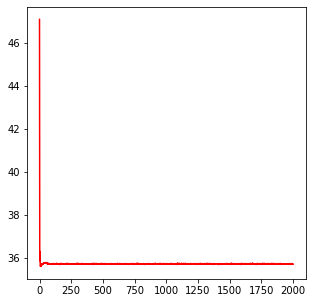

In [12]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(A_vec_lc_s.shape[0]),A_vec_lc_s[:,80], color='r')

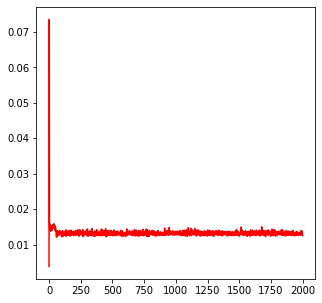

In [13]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(beta_vec_lc_s.shape[0]),beta_vec_lc_s[:,0], color='r')

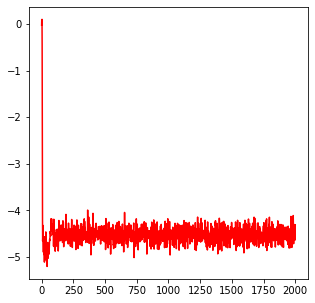

In [396]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(B_vec_lc_s.shape[0]),B_vec_lc_s[:,0], color='r')

In [59]:
burn_in = 300
A_lc_s_best = np.median(A_vec_lc_s[burn_in:,],axis=0)
beta_lc_s_best = np.median(beta_vec_lc_s[burn_in:], axis = 0)
eta_lc_s_best = np.median(B_vec_lc_s[burn_in:], axis = 0)
w_lc_s_best  = np.median(w_lc_s[burn_in:], axis = 0)
v_lc_s_best  = np.median(v_lc_s[burn_in:], axis = 0)

# Kalman parameters
n_stock = y.shape[1]
nr_groups = len(np.unique(group_membership))

F = np.zeros((n_stock, 1 + nr_groups))
F[:,0] = beta_lc_s_best[:n_stock]
F[range(F.shape[0]), group_membership + 1] = 1
F[:,1:F.shape[1]] = np.multiply(F[:,1:F.shape[1]], beta_lc_s_best[n_stock:])

init_x = np.array([0.0] * (nr_groups + 1)).reshape(((nr_groups + 1)))
init_c = np.identity((nr_groups + 1)) * 1
G = np.identity(init_x.shape[0])

state, state_cov, state_one_step, state_cov_one_step, y_est = Gibbs.KalmanFilter(y, G, eta_lc_s_best, np.diag(w_lc_s_best), F, A_lc_s_best, v_lc_s_best * np.identity(A_lc_s_best.shape[0]), init_x, init_c)
smooth_state, smooth_state_cov = Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, G, eta_lc_s_best, np.diag(w_lc_s_best))

state = state - np.mean(state, axis=0)
smooth_state = smooth_state - np.mean(smooth_state, axis=0)

y_est_smooth = np.zeros((y.shape[0], y.shape[1]))
for i in range(y.shape[0]):
    y_est_smooth[i] = np.dot(F, smooth_state[i+1]) +  A_lc_s_best
    y_est[i] = np.dot(F, state[i+1]) + A_lc_s_best

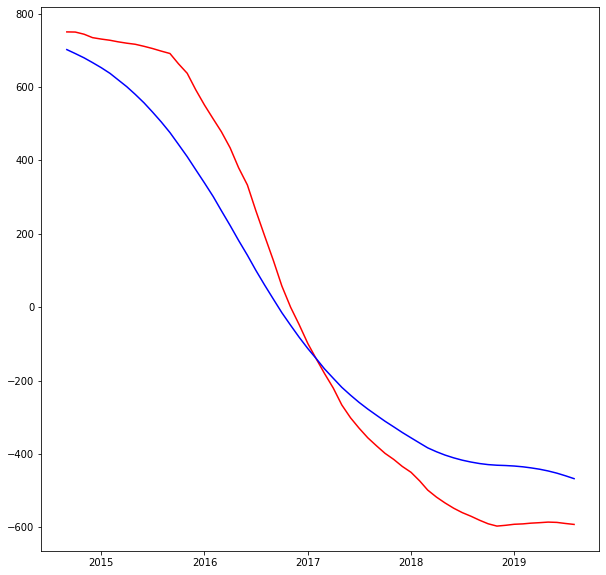

In [15]:
plt.figure(figsize=(10,10))
index = 0
lines_smooth_all = plt.plot(dates, state[1:, index], color='r')
lines_smooth_all = plt.plot(dates, smooth_state[1:, index], color='b')

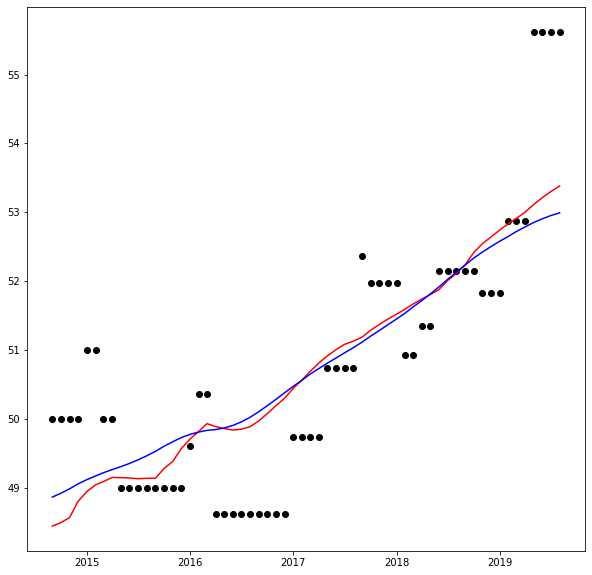

In [35]:
plt.figure(figsize=(10,10))
index = 254
lines_smooth_all = plt.plot(dates, y_est[:, index], color='r')
lines_smooth_all = plt.plot(dates, y_est_smooth[:, index], color='b')
lines_smooth_all = plt.scatter(dates, y[:, index], color='black')

In [33]:
ok = np.array(range(n_stock))
ok[group_membership == 5]

array([ 16,  17,  18,  19,  22,  27,  33,  46,  49,  53,  56,  58,  62,
        66,  70,  71,  80,  85,  88,  90,  96, 113, 163, 167, 182, 186,
       191, 204, 222, 229, 231, 247, 253, 254])

In [22]:
y.shape

(60, 261)

# Lee-carter, sector and market

In [200]:
y = np.array(data_i_will_use)
w_lc_s_m, v_lc_s_m, beta_vec_lc_s_m, A_vec_lc_s_m, B_vec_lc_s_m, states_lc_s_m = Gibbs.lc_sector_market(200, y, group_membership)

C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:550: RuntimeWarning: Mean of empty slice
  alpha_init = np.nanmean(y, axis = 0)


1 of 200
2 of 200
3 of 200
4 of 200
5 of 200
6 of 200
7 of 200
8 of 200
9 of 200
10 of 200
11 of 200
12 of 200
13 of 200
14 of 200
15 of 200
16 of 200
17 of 200
18 of 200
19 of 200
20 of 200
21 of 200
22 of 200
23 of 200
24 of 200
25 of 200


C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:119: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[i-1] = np.random.multivariate_normal(smooth_state[i-1], smooth_state_cov[i-1])


26 of 200
27 of 200
28 of 200
29 of 200
30 of 200
31 of 200
32 of 200
33 of 200
34 of 200
35 of 200
36 of 200
37 of 200
38 of 200
39 of 200
40 of 200
41 of 200
42 of 200
43 of 200
44 of 200
45 of 200
46 of 200
47 of 200
48 of 200
49 of 200
50 of 200
51 of 200
52 of 200
53 of 200
54 of 200
55 of 200
56 of 200
57 of 200
58 of 200
59 of 200
60 of 200
61 of 200
62 of 200
63 of 200
64 of 200
65 of 200
66 of 200
67 of 200
68 of 200
69 of 200
70 of 200
71 of 200
72 of 200
73 of 200
74 of 200
75 of 200
76 of 200
77 of 200
78 of 200
79 of 200
80 of 200
81 of 200
82 of 200
83 of 200
84 of 200
85 of 200
86 of 200
87 of 200
88 of 200
89 of 200
90 of 200
91 of 200
92 of 200
93 of 200
94 of 200
95 of 200
96 of 200
97 of 200
98 of 200
99 of 200
100 of 200
101 of 200
102 of 200
103 of 200
104 of 200
105 of 200
106 of 200
107 of 200
108 of 200
109 of 200
110 of 200
111 of 200
112 of 200
113 of 200
114 of 200
115 of 200
116 of 200
117 of 200
118 of 200
119 of 200
120 of 200
121 of 200
122 of 200
123 of 

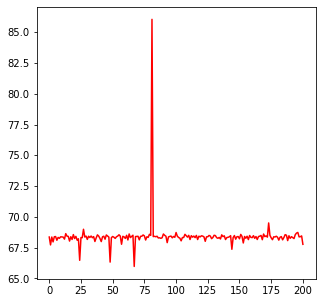

In [201]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(A_vec_lc_s_m.shape[0]),A_vec_lc_s_m[:,0], color='r')

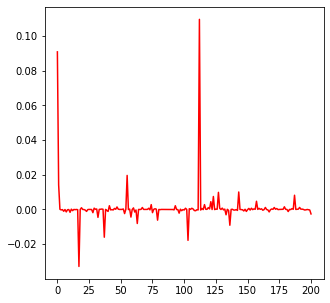

In [203]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(beta_vec_lc_s_m.shape[0]),beta_vec_lc_s_m[:,-1], color='r')

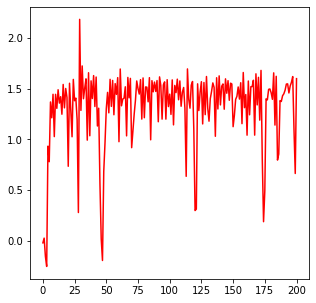

In [190]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(B_vec_lc_s_m.shape[0]),B_vec_lc_s_m[:,0], color='r')

In [204]:
burn_in = 30
A_lc_s_m_best = np.median(A_vec_lc_s_m[burn_in:,],axis=0)
beta_lc_s_m_best = np.median(beta_vec_lc_s_m[burn_in:], axis = 0)
eta_lc_s_m_best = np.median(B_vec_lc_s_m[burn_in:], axis = 0)
w_lc_s_m_best  = np.median(w_lc_s_m[burn_in:], axis = 0)
v_lc_s_m_best  = np.median(v_lc_s_m[burn_in:], axis = 0)

# Kalman parameters
n_stock = y.shape[1]
nr_groups = len(np.unique(group_membership))

F = np.zeros((n_stock, 1 + nr_groups + 1))
F[:,0] = beta_lc_s_m_best[:n_stock]
F[:,-1] = beta_lc_s_m_best[-1]
F[range(F.shape[0]), group_membership + 1] = 1
F[:,1:(F.shape[1]-1)] = np.multiply(F[:,1:(F.shape[1]-1)], beta_lc_s_m_best[n_stock:(n_stock + nr_groups)])

init_x = np.array([0.0] * (1 + nr_groups + 1)).reshape(((1 + nr_groups + 1)))
init_c = np.identity((1 + nr_groups + 1)) * 1
G = np.identity(init_x.shape[0])

state, state_cov, state_one_step, state_cov_one_step, y_est = Gibbs.KalmanFilter(y, G, eta_lc_s_m_best, np.diag(w_lc_s_m_best), F, A_lc_s_m_best, v_lc_s_m_best * np.identity(A_lc_s_m_best.shape[0]), init_x, init_c)
smooth_state, smooth_state_cov = Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, G, eta_lc_s_m_best, np.diag(w_lc_s_m_best))

y_est_smooth = np.zeros((y.shape[0], y.shape[1]))
for i in range(y.shape[0]):
    y_est_smooth[i] = np.dot(F, smooth_state[i+1]) + A_lc_s_m_best
    y_est[i] = np.dot(F, state[i+1]) + A_lc_s_m_best

In [210]:
print(beta_lc_s_m_best[n_stock:])

[-3.44732079e-11 -1.11271001e-09  4.35719495e-06 -6.67422266e-06
 -9.97143059e-06 -3.51482507e-05 -2.08860633e-05  6.51417446e-05
 -5.74242872e-06  6.01880334e-06  2.91673598e-06  9.99920700e-01]


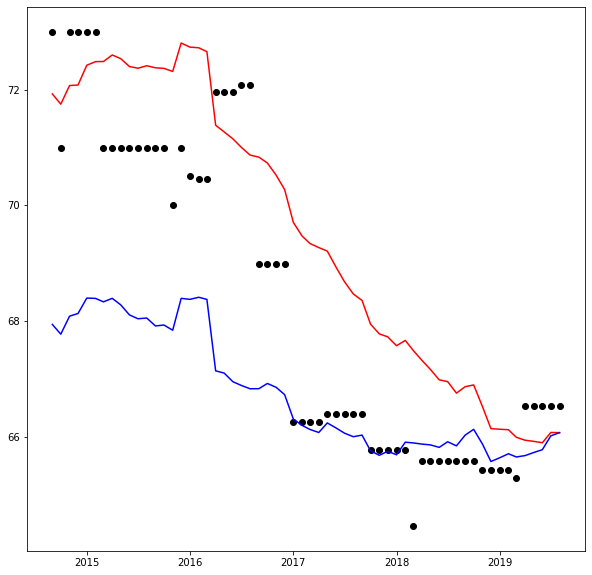

In [206]:
plt.figure(figsize=(10,10))
index = 0
lines_smooth_all = plt.plot(dates, y_est[:, index], color='r')
lines_smooth_all = plt.plot(dates, y_est_smooth[:, index], color='b')
lines_smooth_all = plt.scatter(dates, y[:, index], color='black')

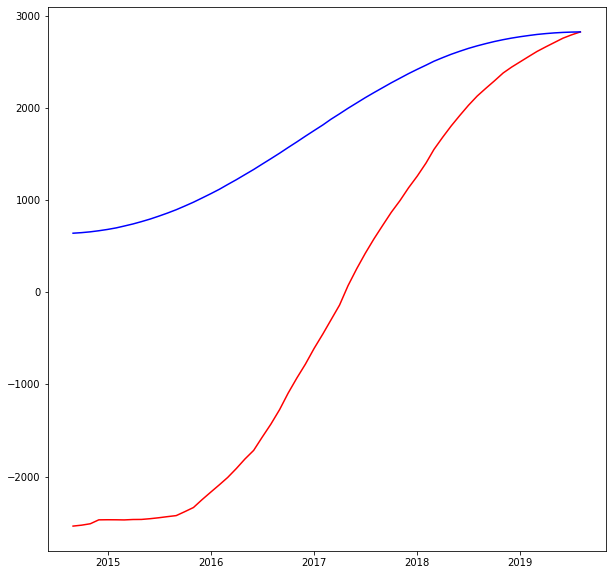

In [207]:
plt.figure(figsize=(10,10))
index = 0
lines_smooth_all = plt.plot(dates, state[1:, index], color='r')
lines_smooth_all = plt.plot(dates, smooth_state[1:, index], color='b')

# Lee Carter sector and shift

Data

In [36]:
data_i_will_use_shift = esg_pivot.copy().dropna(axis = 0, how = 'all' ).iloc[:].copy().dropna(axis = 1, how = 'all' ).copy()
dates_shift = np.array(data_i_will_use_shift.index)

In [62]:
group_membership_shift = []
for i in list(data_i_will_use_shift.columns):
    sector = asset_profiles['sector'].loc[asset_profiles['ticker'] == i].iloc[0]
    if sector == 'Basic Materials':
        group_membership_shift.append(0)
    elif sector == 'Communication Services':
        group_membership_shift.append(1)
    elif sector == 'Consumer Cyclical':
        group_membership_shift.append(2)
    elif sector == 'Consumer Defensive':
        group_membership_shift.append(3)
    elif sector == 'Energy':
        group_membership_shift.append(4)
    elif sector == 'Financial Services':
        group_membership_shift.append(5)
    elif sector == 'Healthcare':
        group_membership_shift.append(6)
    elif sector == 'Industrials':
        group_membership_shift.append(7)
    elif sector == 'Real Estate':
        group_membership_shift.append(8)
    elif sector == 'Technology':
        group_membership_shift.append(9)
    elif sector == 'Utilities':
        group_membership_shift.append(10)

group_membership_shift = np.array(group_membership_shift)

In [42]:
y_shift = np.array([0] * data_i_will_use_shift.shape[1])
index = np.array(range(data_i_will_use_shift.shape[0]))
for i in range(len(data_i_will_use_shift.columns)):
    tmp = index[(data_i_will_use_shift.iloc[:,i].index > datetime.date(2019,9,1)) & (data_i_will_use_shift.iloc[:,i].diff() < -10)]
    if len(tmp) == 0:
        y_shift[i] = 999999
    else:
        y_shift[i] = tmp[0]


In [43]:
importlib.reload(sys.modules['Gibbs'])
y_data_shift = np.array(data_i_will_use_shift)
n_stock_shift = data_i_will_use_shift.shape[1]
nr_groups_shift = len(np.unique(group_membership_shift))
w_lc_s_s, v_lc_s_s, beta_vec_lc_s_s, A_vec_lc_s_s, B_vec_lc_s_s, states_lc_s_s = Gibbs.lc_sector_level_shift(2000, y_data_shift, group_membership_shift, y_shift)

C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:740: RuntimeWarning: Mean of empty slice
  alpha_init[1,j] = np.nanmean(y[y_shift[j]:, j])


1 of 2000
2 of 2000
3 of 2000
4 of 2000
5 of 2000


C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:131: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[i-1] = np.random.multivariate_normal(smooth_state[i-1], smooth_state_cov[i-1])


6 of 2000
7 of 2000
8 of 2000
9 of 2000
10 of 2000
11 of 2000
12 of 2000
13 of 2000
14 of 2000
15 of 2000
16 of 2000
17 of 2000
18 of 2000
19 of 2000
20 of 2000
21 of 2000
22 of 2000
23 of 2000
24 of 2000
25 of 2000
26 of 2000
27 of 2000
28 of 2000
29 of 2000
30 of 2000
31 of 2000
32 of 2000
33 of 2000
34 of 2000
35 of 2000
36 of 2000
37 of 2000
38 of 2000
39 of 2000
40 of 2000
41 of 2000
42 of 2000
43 of 2000
44 of 2000
45 of 2000
46 of 2000
47 of 2000
48 of 2000
49 of 2000
50 of 2000
51 of 2000
52 of 2000
53 of 2000
54 of 2000
55 of 2000
56 of 2000
57 of 2000
58 of 2000
59 of 2000
60 of 2000
61 of 2000
62 of 2000
63 of 2000
64 of 2000
65 of 2000
66 of 2000
67 of 2000
68 of 2000
69 of 2000
70 of 2000
71 of 2000
72 of 2000
73 of 2000
74 of 2000
75 of 2000
76 of 2000
77 of 2000
78 of 2000
79 of 2000
80 of 2000
81 of 2000
82 of 2000
83 of 2000
84 of 2000
85 of 2000
86 of 2000
87 of 2000
88 of 2000
89 of 2000
90 of 2000
91 of 2000
92 of 2000
93 of 2000
94 of 2000
95 of 2000
96 of 2000
97 

C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:118: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[-1] = np.random.multivariate_normal(smooth_state[-1], smooth_state_cov[-1])


linalg error
1681 of 2000
1682 of 2000
1683 of 2000
1684 of 2000
1685 of 2000
1686 of 2000
1687 of 2000
1688 of 2000
1689 of 2000
1690 of 2000
1691 of 2000
1692 of 2000
1693 of 2000
1694 of 2000
1695 of 2000
1696 of 2000
1697 of 2000
1698 of 2000
1699 of 2000
1700 of 2000
1701 of 2000
1702 of 2000
1703 of 2000
1704 of 2000
1705 of 2000
1706 of 2000
1707 of 2000
1708 of 2000
1709 of 2000
1710 of 2000
1711 of 2000
1712 of 2000
1713 of 2000
1714 of 2000
1715 of 2000
1716 of 2000
1717 of 2000
1718 of 2000
1719 of 2000
1720 of 2000
1721 of 2000
1722 of 2000
1723 of 2000
1724 of 2000
1725 of 2000
1726 of 2000
1727 of 2000
1728 of 2000
1729 of 2000
1730 of 2000
1731 of 2000
1732 of 2000
1733 of 2000
1734 of 2000
1735 of 2000
1736 of 2000
1737 of 2000
1738 of 2000
1739 of 2000
1740 of 2000
1741 of 2000
1742 of 2000
1743 of 2000
1744 of 2000
1745 of 2000
1746 of 2000
1747 of 2000
1748 of 2000
1749 of 2000
1750 of 2000
1751 of 2000
1752 of 2000
1753 of 2000
1754 of 2000
1755 of 2000
1756 of 2000

(0.0, 100.0)

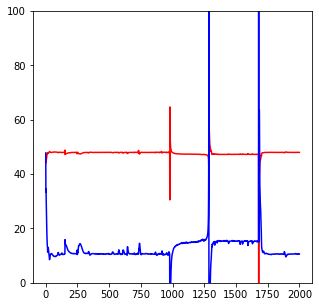

In [150]:
plt.figure(figsize=(5,5))
index = 2
lines_smooth_all = plt.plot(range(A_vec_lc_s_s.shape[0]),A_vec_lc_s_s[:,0,index], color='r')
lines_smooth_all = plt.plot(range(A_vec_lc_s_s.shape[0]),A_vec_lc_s_s[:,-1,index], color='b')
plt.ylim([0,100])

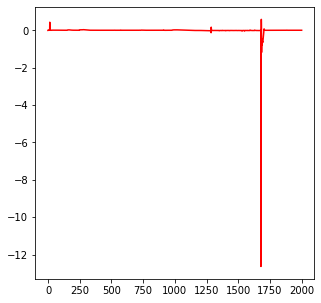

In [151]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(beta_vec_lc_s_s.shape[0]),beta_vec_lc_s_s[:,0], color='r')

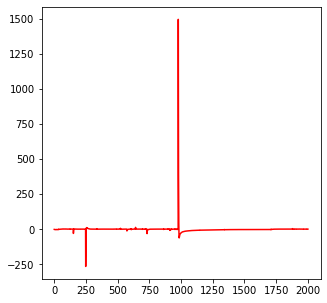

In [47]:
plt.figure(figsize=(5,5))
lines_smooth_all = plt.plot(range(B_vec_lc_s_s.shape[0]),B_vec_lc_s_s[:,0], color='r')

In [141]:
burn_in = 100
A_lc_s_s_best = A_vec_lc_s_s[150]
beta_lc_s_s_best = np.median(beta_vec_lc_s_s[burn_in:], axis = 0)
eta_lc_s_s_best = np.median(B_vec_lc_s_s[burn_in:], axis = 0)
w_lc_s_s_best  = np.median(w_lc_s_s[burn_in:], axis = 0)
v_lc_s_s_best  = np.median(v_lc_s_s[burn_in:], axis = 0)

# Kalman parameters
importlib.reload(sys.modules['Gibbs'])
F = np.zeros((n_stock_shift, 1 + nr_groups_shift))
F[:,0] = beta_lc_s_s_best[:n_stock_shift]
F[range(F.shape[0]), group_membership_shift + 1] = 1
F[:,1:F.shape[1]] = np.multiply(F[:,1:F.shape[1]], beta_lc_s_s_best[n_stock_shift:])

init_x = np.array([0.0] * (nr_groups_shift + 1)).reshape(((nr_groups_shift + 1)))
init_c = np.identity((nr_groups_shift + 1)) * 1
G = np.identity(init_x.shape[0])

state, state_cov, state_one_step, state_cov_one_step, y_est = Gibbs.KalmanFilter(y_data_shift, G, eta_lc_s_s_best, np.diag(w_lc_s_s_best), F, A_lc_s_s_best, v_lc_s_s_best * np.identity(n_stock_shift), init_x, init_c)
smooth_state, smooth_state_cov = Gibbs.KalmanSmooth(state, state_one_step, state_cov, state_cov_one_step, G, eta_lc_s_s_best, np.diag(w_lc_s_s_best))

state = state - np.mean(state, axis=0)
smooth_state = smooth_state - np.mean(smooth_state, axis=0)

y_est_smooth = np.zeros((data_i_will_use_shift.shape[0], data_i_will_use_shift.shape[1]))
for i in range(y_data_shift.shape[0]):
    tmp = np.dot(F, smooth_state[i+1]) + A_lc_s_s_best[i]
    y_est_smooth[i] = np.dot(F, smooth_state[i+1]) + A_lc_s_s_best[i]
    y_est[i] = np.dot(F, state[i+1]) + A_lc_s_s_best[i]

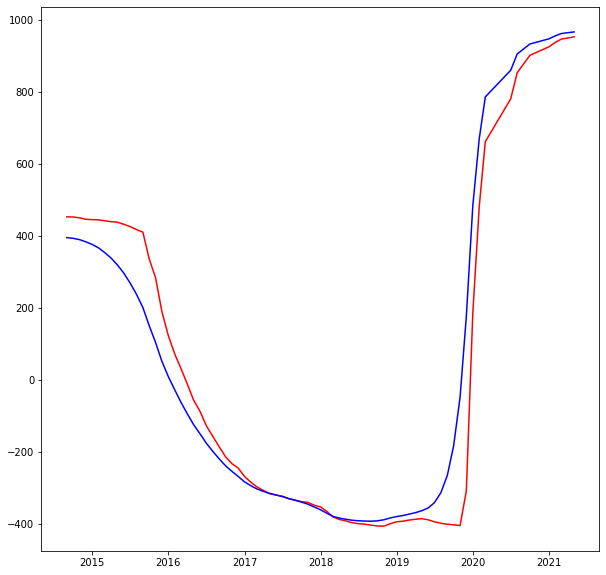

In [142]:
plt.figure(figsize=(10,10))
index = 0
lines_smooth_all = plt.plot(dates_shift, state[1:, index], color='r')
lines_smooth_all = plt.plot(dates_shift, smooth_state[1:, index], color='b')

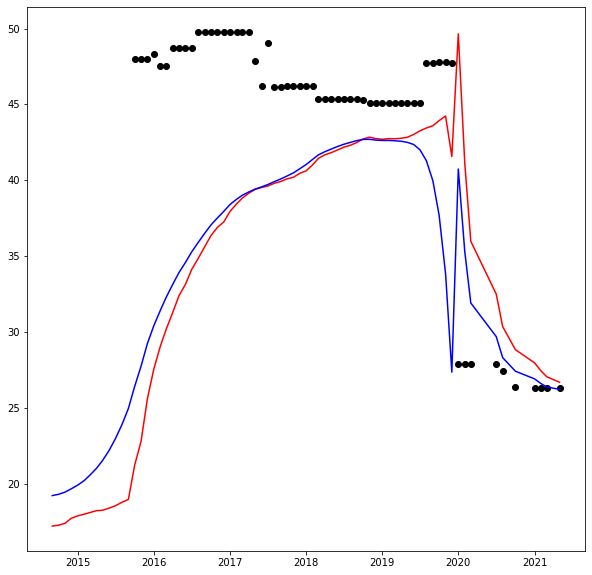

In [148]:
plt.figure(figsize=(10,10))
index = 80
lines_smooth_all = plt.plot(dates_shift, y_est[:, index], color='r')
lines_smooth_all = plt.plot(dates_shift, y_est_smooth[:, index], color='b')
lines_smooth_all = plt.scatter(dates_shift, data_i_will_use_shift.iloc[:, index], color='black')

In [106]:
y_est_smooth

array([[72.01253352, 55.45903557, 48.45195018, ...,  0.92767334,
        64.30904391, 59.03778735],
       [72.0091088 , 55.44617965, 48.45277025, ...,  0.95121967,
        64.31203403, 59.04314075],
       [72.0703755 , 55.43416847, 48.44949647, ...,  1.0649556 ,
        64.31223491, 59.12148433],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# Lee-Carter, esg sector

## Regularization = 0.1

In [15]:
importlib.reload(sys.modules['Gibbs'])
y = np.array(data_median_shift)
n_stock = y.shape[1]
nr_groups = len(np.unique(group_membership_median_shift))

reg_params = {'reg_f':0.1}
w_lc_s, v_lc_s, beta_vec_lc_s, A_vec_lc_s, B_vec_lc_s, states_lc_s, R_conds = Gibbs.lc_sector(2000, y, group_membership_median_shift, calc_cond=True, reg_params = reg_params)

T 74, n_stock 282, n_groups 11
1 of 2000 
1000.000000000806 vs 10.89108910891101
2 of 2000 
6669.3028856792125 vs 3688.0291839152774
3 of 2000 
14986.82477848906 vs 9842.052119140042
4 of 2000 
2097.2674872561283 vs 1562.416322436963
5 of 2000 
3775.655420124333 vs 2120.597843653308
6 of 2000 
2233.71144301234 vs 1362.201331772782
7 of 2000 
1386.3072657042787 vs 833.0300667074414
8 of 2000 
1661.9978925898545 vs 961.0534818488402
9 of 2000 
2204.149282024193 vs 1270.4195741693252
10 of 2000 
1789.5866643430993 vs 1019.883520977606
11 of 2000 
12718.58177674656 vs 6805.560267259915
12 of 2000 
8811.766549476019 vs 4287.888623015478
13 of 2000 
1868.7334853203897 vs 1050.8160457566914
14 of 2000 
9993.871289054521 vs 4863.488727491908
15 of 2000 
17428.375608053106 vs 8781.974331363464
16 of 2000 
2395.8170481145776 vs 1340.259143365382
17 of 2000 
2134.718843069157 vs 1095.2386805495491
18 of 2000 
2101.722678099858 vs 1174.8396766202795
19 of 2000 
1849.4106876892206 vs 1021.455562809

C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:263: RuntimeWarning: invalid value encountered in power
  tmp2 = A_vec[i-1, j]**smooth_state_new[:,1 + group_membership[j]]


1145075.3915761863 vs 583703.8715046445
826 of 2000 
51364.09838679287 vs 42955.86145072671
827 of 2000 
24279.701853055205 vs 15271.427806797385
828 of 2000 
19126.734111797017 vs 11893.506444852736
829 of 2000 
6920.23010689343 vs 3803.2771785918594
830 of 2000 
6998.535555444328 vs 3830.2257101456635
831 of 2000 
7849.934058970584 vs 3747.4471680293605
832 of 2000 
8874.065126709558 vs 4302.790414034541
833 of 2000 
2306.84615738121 vs 1304.1864098427925
834 of 2000 
148531.97636766496 vs 92712.92364247596
835 of 2000 
117568.92689898971 vs 60357.73480608264
836 of 2000 
1615.9604980440622 vs 1027.574184803046
837 of 2000 
2194.3017838450182 vs 1155.380944196364
838 of 2000 
46326.5625060325 vs 24114.042299838464
839 of 2000 
7146.899466955275 vs 4228.372433773853
840 of 2000 
1837.7120529124902 vs 1084.2622850671767
841 of 2000 
1610.8156332709884 vs 875.7653235977397
842 of 2000 
3403.7832695582642 vs 1828.5314799738896
843 of 2000 
4713.850244114162 vs 2704.279472095409
844 of 20

Text(0.5, 1.0, 'variance_x, x= 0')

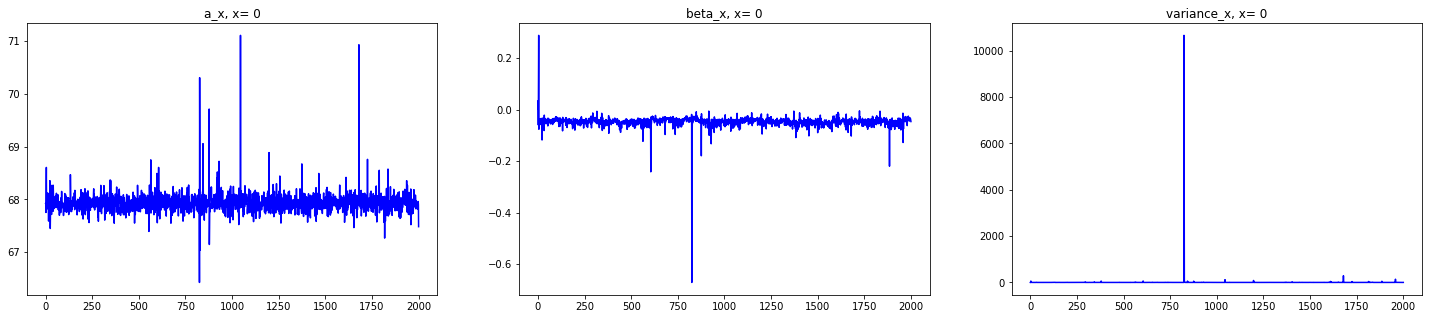

In [17]:
index = 0
# print(f'a_x = {A_vec_lc_s[index]}, beta_i = {beta_vec_lc_s[index]}, v = {v_lc_s[index]}')

fig, ax = plt.subplots(1,3, figsize = (25,5))
ax[0].plot(range(A_vec_lc_s.shape[0]),A_vec_lc_s[:,index], color='b')
ax[0].set_title(f'a_x, x= {index}')
ax[1].plot(range(beta_vec_lc_s.shape[0]),beta_vec_lc_s[:,index], color='b')
ax[1].set_title(f'beta_x, x= {index}')
ax[2].plot(range(v_lc_s.shape[0]),v_lc_s[:,index], color='b')
ax[2].set_title(f'variance_x, x= {index}')
#ax[2].set_ylim(ymax = 0.15)

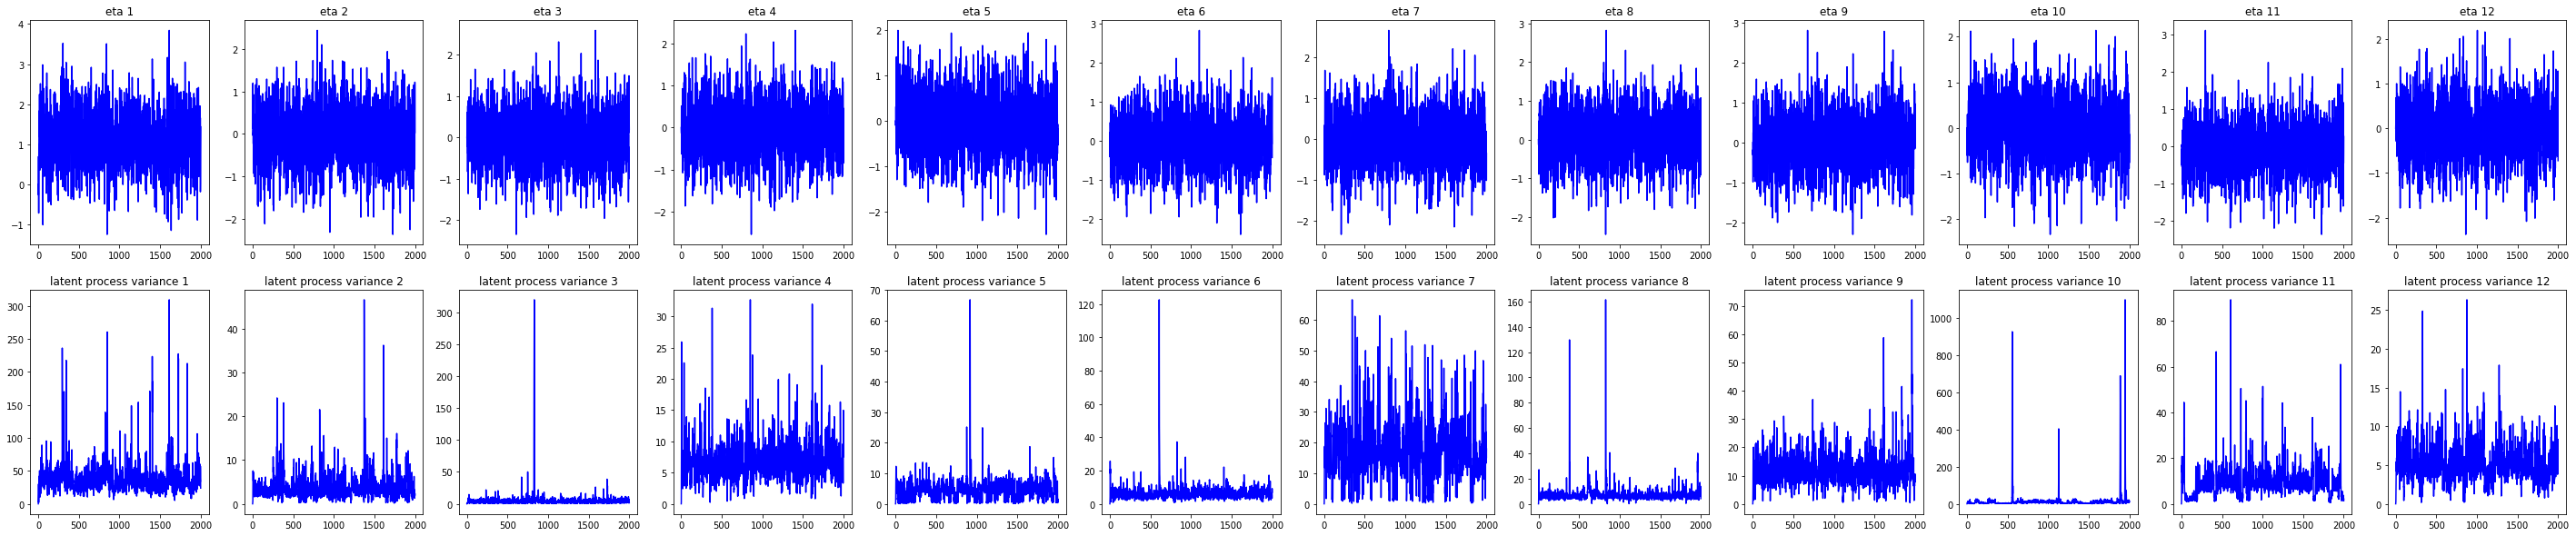

In [18]:
fig, ax = plt.subplots(2,12, figsize = (50,10))
for j in range(12):

        ax[0,j].plot(range(B_vec_lc_s.shape[0]),B_vec_lc_s[:,j], color='b')
        ax[0,j].set_title(f'eta {j+1}')
        ax[1,j].plot(range(w_lc_s.shape[0]),w_lc_s[:,j], color='b')
        ax[1,j].set_title(f'latent process variance {j+1}')

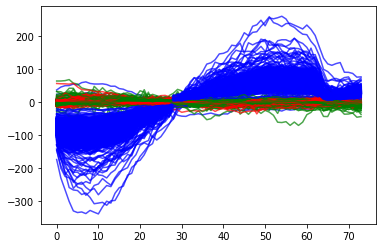

In [19]:
for i in range(states_lc_s.shape[0]):
    plt.plot(range(states_lc_s.shape[1]), states_lc_s[i, :, 0], color = 'blue', alpha =0.7)
    plt.plot(range(states_lc_s.shape[1]), states_lc_s[i, :, 1], color = 'red', alpha =0.7)
    plt.plot(range(states_lc_s.shape[1]), states_lc_s[i, :, 2], color = 'green', alpha =0.7)

## Regularization = 0.5

In [20]:
importlib.reload(sys.modules['Gibbs'])
y = np.array(data_median_shift)
n_stock = y.shape[1]
nr_groups = len(np.unique(group_membership_median_shift))

reg_params = {'reg_f':0.5}
w_2, v_2, beta_vec_2, A_vec_2, B_vec_2, states_2, R_conds_2 = Gibbs.lc_sector(100, y, group_membership_median_shift, calc_cond=True, reg_params = reg_params)

T 74, n_stock 282, n_groups 11
1 of 100 


KeyboardInterrupt: 

Text(0.5, 1.0, 'variance_x, x= 0')

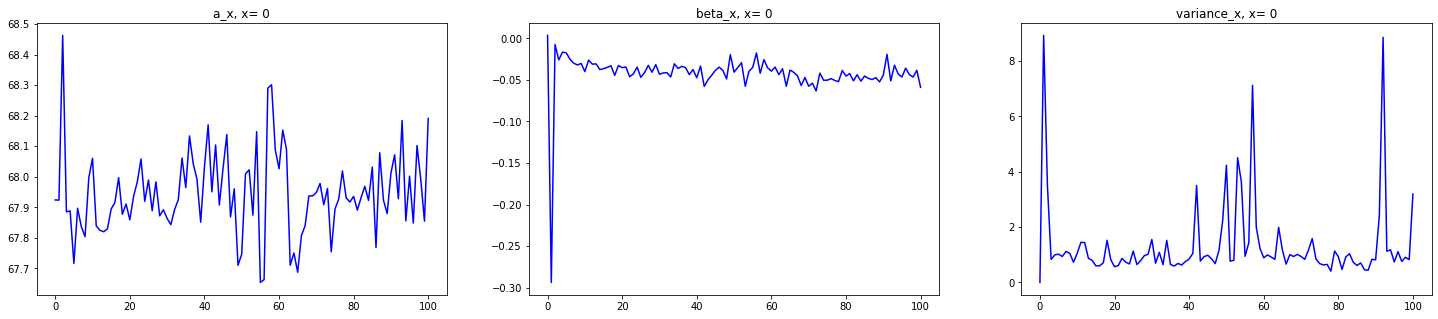

In [21]:
index = 0
# print(f'a_x = {A_vec_lc_s[index]}, beta_i = {beta_vec_lc_s[index]}, v = {v_lc_s[index]}')

fig, ax = plt.subplots(1,3, figsize = (25,5))
ax[0].plot(range(A_vec_2.shape[0]),A_vec_2[:,index], color='b')
ax[0].set_title(f'a_x, x= {index}')
ax[1].plot(range(beta_vec_2.shape[0]),beta_vec_2[:,index], color='b')
ax[1].set_title(f'beta_x, x= {index}')
ax[2].plot(range(v_2.shape[0]),v_2[:,index], color='b')
ax[2].set_title(f'variance_x, x= {index}')
#ax[2].set_ylim(ymax = 0.15)

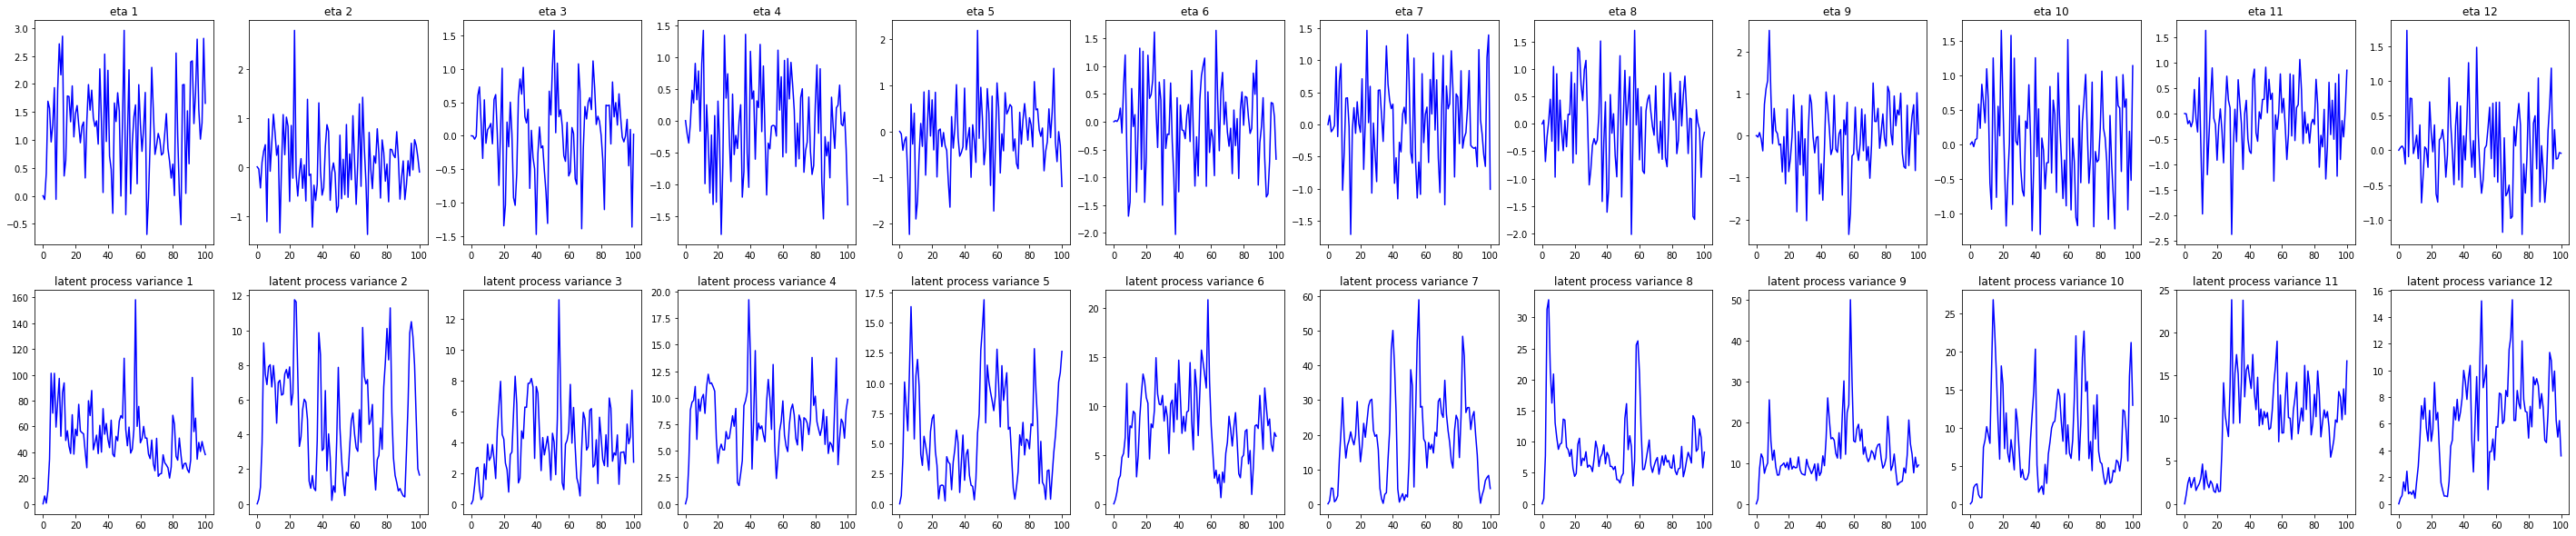

In [22]:
fig, ax = plt.subplots(2,12, figsize = (50,10))
for j in range(12):

        ax[0,j].plot(range(B_vec_2.shape[0]),B_vec_2[:,j], color='b')
        ax[0,j].set_title(f'eta {j+1}')
        ax[1,j].plot(range(w_2.shape[0]),w_2[:,j], color='b')
        ax[1,j].set_title(f'latent process variance {j+1}')

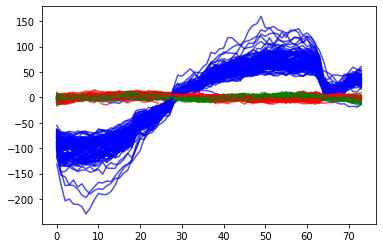

In [23]:
for i in range(states_2.shape[0]):
    plt.plot(range(states_2.shape[1]), states_2[i, :, 0], color = 'blue', alpha =0.7)
    plt.plot(range(states_2.shape[1]), states_2[i, :, 1], color = 'red', alpha =0.7)
    plt.plot(range(states_2.shape[1]), states_2[i, :, 2], color = 'green', alpha =0.7)

# Simulation

Test gibbs sampler for simulated data

In [22]:
eta = np.array([-0.01, -0.15, -0.1, -0.07, -0.08])
w = np.array([0.3, 0.5, 0.55, 0.55, 0.7])
beta_i = np.random.uniform(0.01, 0.8, 40)
beta_s_i = np.random.uniform(0.01, 0.8, 40)
a_x = np.random.uniform(50, 80, 40)
N = 50
v = np.random.uniform(0.02, 0.08, 40)

yo = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)

x = np.zeros((N + 1, 5))
# generate latent
for i in range(1, N+1):
    x[i, 0] = x[i-1, 0] + eta[0] + np.random.normal(loc = 0, scale = w[0])
    x[i, 1] = x[i-1, 1] + eta[1] + np.random.normal(loc = 0, scale = w[1])
    x[i, 2] = x[i-1, 2] + eta[2] + np.random.normal(loc = 0, scale = w[2])
    x[i, 3] = x[i-1, 3] + eta[3] + np.random.normal(loc = 0, scale = w[3])
    x[i, 4] = x[i-1, 4] + eta[4] + np.random.normal(loc = 0, scale = w[4])

y = np.zeros((N, 40))
for i in range(N):
    for j in range(40):
        if j < 10:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])
        elif j < 20:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,2] + np.random.normal(0, v[j])
        elif j < 30:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,3] + np.random.normal(0, v[j])
        elif j < 40:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,4] + np.random.normal(0, v[j])

In [23]:
y = np.zeros((N, 40))
for i in range(N):
    for j in range(40):
        if j < 10:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])
        elif j < 20:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,2] + np.random.normal(0, v[j])
        elif j < 30:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,3] + np.random.normal(0, v[j])
        elif j < 40:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,4] + np.random.normal(0, v[j])
        #y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])


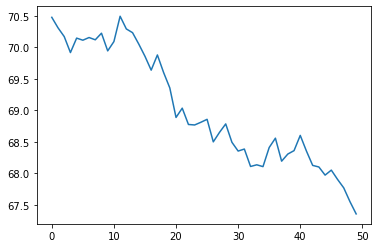

In [214]:
plt.plot(range(N), y[:, 0])

In [360]:
F = np.zeros((40, 1 + 1))
F[:,0] = beta_i
for j in range(F.shape[0]):
    F[j, 1] = beta_s_i[j]

In [24]:
beta_vec = np.concatenate((beta_i, beta_s_i))
F = np.zeros((40, 1 + 4))
F[:,0] = beta_vec[:40]
for j in range(F.shape[0]):
    F[j, yo[j] + 1] = beta_vec[ 40 + j]

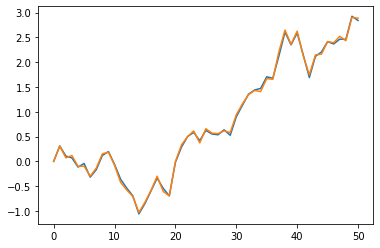

In [25]:

importlib.reload(sys.modules['Gibbs'])
state, state_cov, state_one_step, state_cov_one_step, y_est, R_cond = Gibbs.KalmanFilter(y, np.identity(5), B = eta, W = np.diag(w), F = F, A = a_x, V = np.diag(v), init_x = np.zeros(5), init_c = np.diag([1,1,1,1,1]))
plt.plot(range(N+1), state[:, 0])
plt.plot(range(N+1), x[:, 0])

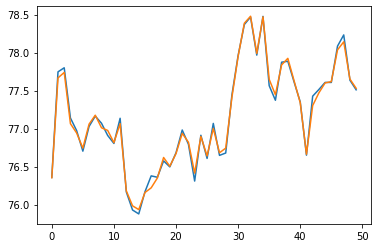

In [26]:
plt.plot(range(N), y[:,24])
plt.plot(range(N), y_est[:,24])

In [144]:
state_cov_one_step.shape

(50, 5, 5)

In [146]:
importlib.reload(sys.modules['Gibbs'])
smooth_state, smooth_state_cov = Gibbs.KalmanSmooth(state, state_one_step,state_cov,state_cov_one_step, np.identity(5), eta, np.diag(w))

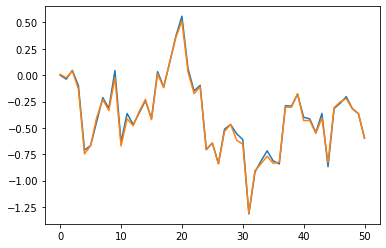

In [150]:
plt.plot(range(N+1), state[:, 0])
plt.plot(range(N+1), smooth_state[:, 0])

In [164]:
smooth_state_draws = np.zeros((100, state.shape[0], state.shape[1]))
for i in range(100):
    smooth_state_draws[i], R_cond = Gibbs.FFBS(y, np.identity(5), B = eta, W = np.diag(w), F = F, A = a_x, V = np.diag(v), init_x = np.zeros(5), init_c = np.diag([0.1,0.1,0.1,0.1,0.1]))

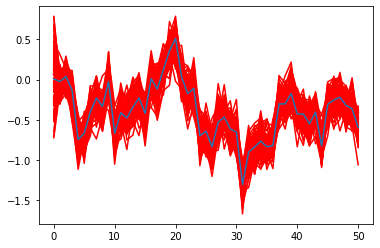

In [165]:
for i in range(100):
    plt.plot(range(N+1), smooth_state_draws[i,:, 0], color = 'r')

plt.plot(range(N+1), smooth_state[:, 0])

In [207]:
importlib.reload(sys.modules['Gibbs'])
# groups_memb = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)
groups_memb = np.array([0] * 40 )
w_g, v_g, beta, A, B, states, R_conds = Gibbs.lc_sector(300, y, groups_memb, calc_cond=False)


T 50, n_stock 40, nr_groups 1
1 of 300 
2.4999993750001564e-06
2 of 300 
0.0001495104684592795
3 of 300 
9.290179313204717e-06
4 of 300 
3.140027784241472e-05
5 of 300 
1.947012143208858e-05
6 of 300 
3.3185158341579135e-05
7 of 300 
3.63708878120482e-05
8 of 300 
2.77984138299003e-05
9 of 300 
4.219605516559445e-05
10 of 300 
2.527084158498063e-05
11 of 300 
2.6537416210241616e-05
12 of 300 
3.20371087319755e-05
13 of 300 
1.9949004701254138e-05
14 of 300 
4.19213121579296e-05
15 of 300 
3.440207422850487e-05
16 of 300 
3.0455300314623723e-05
17 of 300 
2.602080721079445e-05
18 of 300 
5.166880853635329e-05
19 of 300 
3.5291639362551615e-05
20 of 300 
5.877774220264816e-05
21 of 300 
3.768834837321468e-05
22 of 300 
3.9580671147382716e-05
23 of 300 
3.480659240060199e-05
24 of 300 
3.650759241571073e-05
25 of 300 
5.9108589107828035e-05
26 of 300 
3.072090132507872e-05
27 of 300 
4.4501420037985926e-05
28 of 300 
3.11205876758854e-05
29 of 300 
5.144179449434977e-05
30 of 300 
2.42902

C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:127: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[-1] = np.random.multivariate_normal(smooth_state[-1], smooth_state_cov[-1])
C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:140: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[i-1] = np.random.multivariate_normal(smooth_state[i-1], smooth_state_cov[i-1])


3.3743768792991696e-05
79 of 300 
6.645772432059851e-06
80 of 300 
9.213979019014271e-05
81 of 300 
1.4239697006721446e-05
82 of 300 
3.284238819664405e-05
83 of 300 
2.181559756595078e-05
84 of 300 
8.585155445619365e-06
85 of 300 
4.458630211990183e-05
86 of 300 
3.946567552557773e-05
87 of 300 
1.872243623911638e-05
88 of 300 
6.927730701587308e-06
89 of 300 
6.805252962926162e-05
90 of 300 
3.246972147403697e-05
91 of 300 
3.06739650894303e-05
92 of 300 
1.605175832155723e-05
93 of 300 
3.2234030938062e-05
94 of 300 
2.4656400644512455e-05
95 of 300 
5.849941143547578e-05
96 of 300 
1.04350652124123e-05
97 of 300 
4.805033203959237e-05
98 of 300 
3.271226343560324e-05
99 of 300 
3.0445750857731037e-05
100 of 300 
8.482178895201607e-06
101 of 300 
5.148956402692243e-05
102 of 300 
2.866299209542232e-05
103 of 300 
2.8297126852461095e-05
104 of 300 
2.146939306353336e-05
105 of 300 
2.585001517924135e-05
106 of 300 
7.605511164695619e-06
107 of 300 
3.24906603610093e-05
108 of 300 
3

# Test 1

In [283]:
eta = np.array([-0.15, -0.15, -0.1, -0.07, -0.08])
w = np.array([0.3, 0.5, 0.55, 0.55, 0.7])
beta_i = np.random.uniform(0.01, 0.8, 40)
beta_s_i = np.random.uniform(0.01, 0.8, 40)
# beta_s_i = beta_s_i/np.sum(beta_s_i)
a_x = np.random.uniform(50, 80, 40)
N = 300
v = np.random.uniform(0.02, 0.08, 40)

yo = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)

x = np.zeros((N + 1, 5))
# generate latent
for i in range(1, N+1):
    x[i, 0] = x[i-1, 0] + eta[0] + np.random.normal(loc = 0, scale = np.sqrt(w[0]))

In [284]:
y = np.zeros((N, 40))
for i in range(N):
    for j in range(40):
        y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + np.random.normal(0, np.sqrt(v[j]))


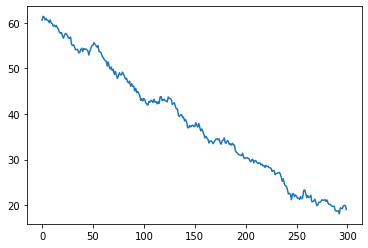

In [286]:
plt.plot(range(y.shape[0]), y[:, 39])

In [285]:
importlib.reload(sys.modules['Gibbs'])
# groups_memb = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)
groups_memb = np.array([0] * 40 )
w_g, v_g, beta, A, B, states, R_conds = Gibbs.lc_sector_test(300, y, x[:,0, np.newaxis], calc_cond=False)

T 300, n_stock 40
1 of 300 
2 of 300 
3 of 300 
4 of 300 
5 of 300 
6 of 300 
7 of 300 
8 of 300 
9 of 300 
10 of 300 
11 of 300 
12 of 300 
13 of 300 
14 of 300 
15 of 300 
16 of 300 
17 of 300 
18 of 300 
19 of 300 
20 of 300 
21 of 300 
22 of 300 
23 of 300 
24 of 300 
25 of 300 
26 of 300 
27 of 300 
28 of 300 
29 of 300 
30 of 300 
31 of 300 
32 of 300 
33 of 300 
34 of 300 
35 of 300 
36 of 300 
37 of 300 
38 of 300 
39 of 300 
40 of 300 
41 of 300 
42 of 300 
43 of 300 
44 of 300 
45 of 300 
46 of 300 
47 of 300 
48 of 300 
49 of 300 
50 of 300 
51 of 300 
52 of 300 
53 of 300 
54 of 300 
55 of 300 
56 of 300 
57 of 300 
58 of 300 
59 of 300 
60 of 300 
61 of 300 
62 of 300 
63 of 300 
64 of 300 
65 of 300 
66 of 300 
67 of 300 
68 of 300 
69 of 300 
70 of 300 
71 of 300 
72 of 300 
73 of 300 
74 of 300 
75 of 300 
76 of 300 
77 of 300 
78 of 300 
79 of 300 
80 of 300 
81 of 300 
82 of 300 
83 of 300 
84 of 300 
85 of 300 
86 of 300 
87 of 300 
88 of 300 
89 of 300 
90 of 300 
9

In [287]:
index = 0
print(f'a_x = {a_x[index]}, beta_i = {beta_i[index]}, v = {v[index]}, w = {w[0]}, eta = {eta[0]}')

a_x = 72.74078196107826, beta_i = 0.5566809005031842, v = 0.03481418287091843, w = 0.3, eta = -0.15


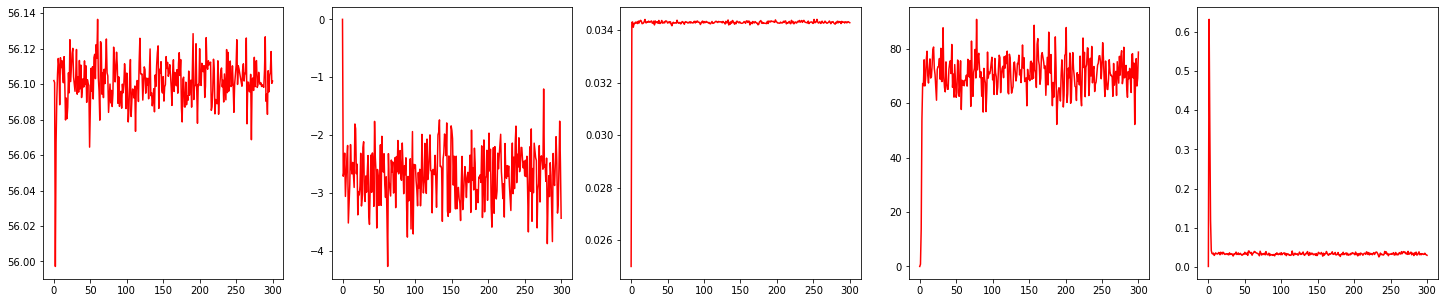

In [288]:
fig, ax = plt.subplots(1,5, figsize = (25,5))
ax[0].plot(range(A.shape[0]),A[:,0], color='r')
ax[1].plot(range(A.shape[0]),B[:,0], color='r')
ax[2].plot(range(A.shape[0]),beta[:,0], color='r')
ax[3].plot(range(A.shape[0]),w_g[:,0], color='r')
ax[4].plot(range(A.shape[0]),v_g[:,0], color='r')


In [265]:
smooth_state_draws_rnd[:, 0]

array([ 4.37021245e+00,  3.52971471e+02,  3.45902111e+02,  3.39320063e+02,
        3.39373624e+02,  3.21806198e+02,  3.17322177e+02,  3.06471029e+02,
        3.13511348e+02,  3.03807658e+02,  2.97562896e+02,  2.90930964e+02,
        2.89808669e+02,  2.80622035e+02,  2.72398751e+02,  2.86413616e+02,
        2.78579970e+02,  2.70629766e+02,  2.79077217e+02,  2.80289735e+02,
        2.82736842e+02,  2.81583861e+02,  2.71277033e+02,  2.61960474e+02,
        2.58303374e+02,  2.61126307e+02,  2.64084567e+02,  2.61464161e+02,
        2.64352416e+02,  2.64959843e+02,  2.67830216e+02,  2.70781542e+02,
        2.63541500e+02,  2.55663540e+02,  2.43022497e+02,  2.51796835e+02,
        2.56688085e+02,  2.66827104e+02,  2.66115320e+02,  2.70121413e+02,
        2.64342466e+02,  2.53108527e+02,  2.51561793e+02,  2.56110477e+02,
        2.52984953e+02,  2.54661120e+02,  2.57311702e+02,  2.55142993e+02,
        2.50692467e+02,  2.52650299e+02,  2.57474894e+02,  2.50866647e+02,
        2.67126937e+02,  

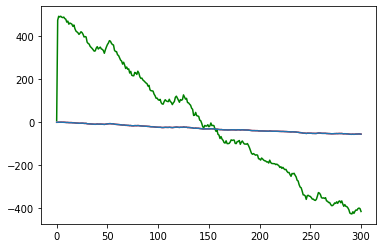

In [290]:
importlib.reload(sys.modules['Gibbs'])
F = np.zeros((y.shape[1], 1))
F[:,0] = beta_i[:]

smooth_state_draws, R_cond = Gibbs.FFBS(y, np.array([[1]]), B = eta[0], W = np.array([[w[0]]]), F = F, A = a_x, V = np.diag(v), init_x = np.zeros(1), init_c = np.diag([0.1]))
F_rnd = np.zeros((y.shape[1], 1))
i = 30
F_rnd[:,0] = beta[i,:]

smooth_state_draws_rnd, R_cond = Gibbs.FFBS(y, np.array([[1]]), B = B[i,0], W = np.array([[w_g[i,0]]]), F = F_rnd, A = A[i,:], V = np.diag(v_g[i,:]), init_x = np.zeros(1) * 100, init_c = np.diag([0.1]))
plt.plot(range(N+1), smooth_state_draws[:, 0], color = 'r')
plt.plot(range(N+1), smooth_state_draws_rnd[:, 0], color = 'g')
plt.plot(range(N+1), x[:, 0])


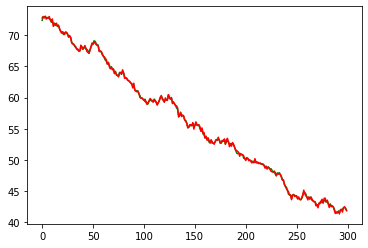

In [291]:
y_est = F_rnd[0,:]*(smooth_state_draws_rnd[1:, 0] - np.mean(smooth_state_draws_rnd[1:, 0])) + A[30,0]

plt.plot(range(y_est.shape[0]), y_est, color = 'g')
plt.plot(range(y.shape[0]), y[:,0], color = 'r')

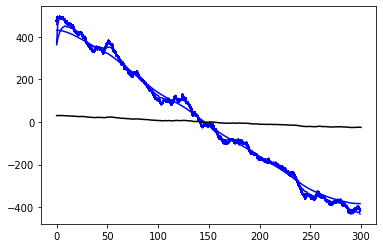

In [292]:
for i in range(states.shape[0]):
    plt.plot(range(states.shape[1]),states[i,:,0], color = 'b')

#plt.plot(range(x.shape[0]), states[0,:,0]/10, color = 'red')
plt.plot(range(x.shape[0]), x[:,0] - np.mean(x[:,0]), color = 'black')

# Test 2

This test is ill-specified. one-dimensional gibbs works

In [16]:
eta = np.array([-0.15, -0.12, -0.1, -0.07, -0.08])
w = np.array([0.3, 0.5, 0.55, 0.55, 0.7])
beta_i = np.ones(40)*0.4 #np.random.uniform(0.01, 0.8, 40)
beta_s_i = np.ones(40)*0.6 # np.random.uniform(0.01, 0.8, 40)
a_x = np.array(40 * [60.0])#np.random.uniform(50, 80, 40)
N = 50
v = np.ones(40)*0.03 # np.random.uniform(0.02, 0.08, 40)

yo = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)

x = np.zeros((N + 1, 5))
# generate latent
for i in range(1, N+1):
    x[i, 0] = x[i-1, 0] + eta[0] + np.random.normal(loc = 0, scale = w[0])
    x[i, 1] = x[i-1, 1] + eta[1] + np.random.normal(loc = 0, scale = w[1])

y = np.zeros((N, 40))
for i in range(N):
    for j in range(40):
        y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])


In [19]:
w[:2]

array([0.3, 0.5])

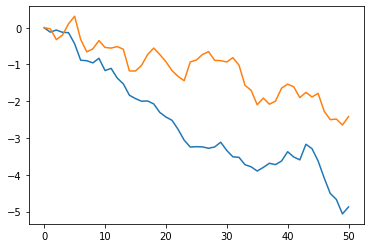

In [17]:
importlib.reload(sys.modules['Gibbs'])
F = np.zeros((y.shape[1], 2))
F[:,0] = beta_i
F[:,1] = beta_s_i
state, state_cov, state_one_step, state_cov_one_step, y_est, R_cond = Gibbs.KalmanFilter(y, np.identity(2), B = eta[:2], W = np.diag(w[:2]), F = F, A = a_x, V = np.diag(v), init_x = np.zeros(2), init_c = np.diag([1,1]))
k = 0
plt.plot(range(N+1), state[:, k])
plt.plot(range(N+1), x[:, k])

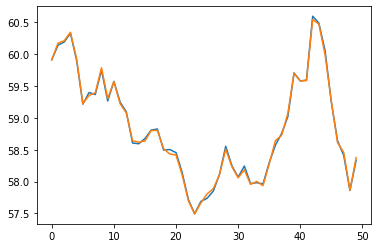

In [21]:
plt.plot(range(N), y[:,24])
plt.plot(range(N), y_est[:,24])

In [33]:
importlib.reload(sys.modules['Gibbs'])
# groups_memb = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)
groups_memb = np.array([0] * 40 )
w_g, v_g, beta, A, B, states, R_conds = Gibbs.lc_sector_test(1000, y,2350, calc_cond=False)

T 50, n_stock 40
1 of 1000 
2 of 1000 
3 of 1000 
4 of 1000 
5 of 1000 
6 of 1000 
7 of 1000 
8 of 1000 
9 of 1000 
10 of 1000 
11 of 1000 
12 of 1000 
13 of 1000 
14 of 1000 
15 of 1000 
16 of 1000 
17 of 1000 
18 of 1000 
19 of 1000 
20 of 1000 
21 of 1000 
22 of 1000 
23 of 1000 
24 of 1000 
25 of 1000 
26 of 1000 
27 of 1000 
28 of 1000 
29 of 1000 
30 of 1000 
31 of 1000 
32 of 1000 
33 of 1000 
34 of 1000 
35 of 1000 
36 of 1000 
37 of 1000 
38 of 1000 
39 of 1000 
40 of 1000 
41 of 1000 
42 of 1000 
43 of 1000 
44 of 1000 
45 of 1000 
46 of 1000 
47 of 1000 
48 of 1000 
49 of 1000 
50 of 1000 
51 of 1000 
52 of 1000 
53 of 1000 
54 of 1000 
55 of 1000 
56 of 1000 
57 of 1000 
58 of 1000 
59 of 1000 
60 of 1000 
61 of 1000 
62 of 1000 
63 of 1000 
64 of 1000 
65 of 1000 
66 of 1000 
67 of 1000 
68 of 1000 
69 of 1000 
70 of 1000 
71 of 1000 
72 of 1000 
73 of 1000 
74 of 1000 
75 of 1000 
76 of 1000 
77 of 1000 
78 of 1000 
79 of 1000 
80 of 1000 
81 of 1000 
82 of 1000 
83 of 10

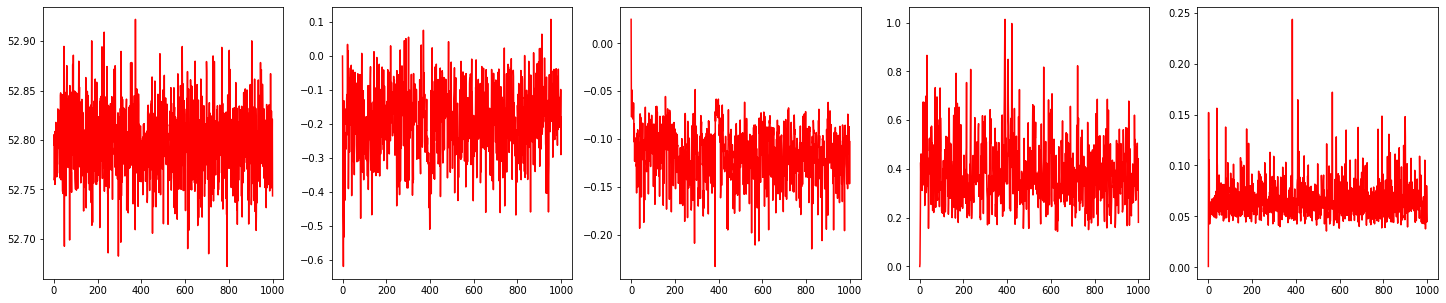

In [34]:
fig, ax = plt.subplots(1,5, figsize = (25,5))
ax[0].plot(range(A.shape[0]),A[:,0], color='r')
ax[1].plot(range(A.shape[0]),B[:,0], color='r')
ax[2].plot(range(A.shape[0]),beta[:,0], color='r')
ax[3].plot(range(A.shape[0]),w_g[:,0], color='r')
ax[4].plot(range(A.shape[0]),v_g[:,0], color='r')


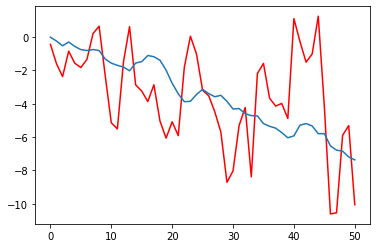

In [353]:
importlib.reload(sys.modules['Gibbs'])
F = np.zeros((y.shape[1], 2))
F[:,0] = beta_i
F[:,1] = beta_s_i
smooth_state_draws, R_cond = Gibbs.FFBS(y, np.identity(2), B = eta[:2], W = np.diag(w[:2]), F = F, A = a_x, V = np.diag(v), init_x = np.zeros(2), init_c = np.diag([0.1] * 2))
F_rnd = np.zeros((y.shape[1], 1))
i = 0
#F_rnd[:,0] = beta[i,:]

#smooth_state_draws_rnd, R_cond = Gibbs.FFBS(y, np.identity(2), B = B[i,0], W = np.diag(w_g[0]), F = F_rnd, A = A[i,:], V = np.diag(v_g[i,:]), init_x = np.zeros(2), init_c = np.diag([0.1] * 2))
plt.plot(range(N+1), smooth_state_draws[:, 0], color = 'r')
#plt.plot(range(N+1), smooth_state_draws_rnd[:, 0], color = 'g')
plt.plot(range(N+1), x[:, 0])


# Test 3

Let's test the Gibbs Sampler

In [165]:


#nr_groups = 4
#eta = np.array([-0.15, 1, -0.5, -2, 2])
#w = np.array([0.3, 0.5, 0.55, 0.55, 0.7])

nr_groups = 2
eta = np.array([-0.15, 0.2, -0.3])
w = np.array([0.3, 0.5, 0.55])

beta_i = np.random.uniform(0.01, 0.8, 40)
beta_s_i = np.random.uniform(0.2, 0.8, 40)
a_x = np.random.uniform(50, 80, 40)
N = 50
v = np.random.uniform(0.02, 0.08, 40)

#group_membership = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)
group_membership = np.array([0] * 20 + [1] * 20 )


x = np.zeros((N + 1, nr_groups + 1))
# generate latent
for i in range(1, N+1):
    x[i, 0] = x[i-1, 0] + eta[0] + np.random.normal(loc = 0, scale = w[0])
    x[i, 1] = x[i-1, 1] + eta[1] + np.random.normal(loc = 0, scale = w[1])
    x[i, 2] = x[i-1, 2] + eta[2] + np.random.normal(loc = 0, scale = w[2])
    #x[i, 3] = x[i-1, 3] + eta[3] + np.random.normal(loc = 0, scale = w[3])
    #x[i, 4] = x[i-1, 4] + eta[4] + np.random.normal(loc = 0, scale = w[4])

y = np.zeros((N, 40))
for i in range(N):
    for j in range(40):
        # if j < 10:
        #     y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])
        # elif j < 20:
        #     y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,2] + np.random.normal(0, v[j])
        # elif j < 30:
        #     y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,3] + np.random.normal(0, v[j])
        # elif j < 40:
        #     y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,4] + np.random.normal(0, v[j])

        if j < 30:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])
        else:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,2] + np.random.normal(0, v[j])

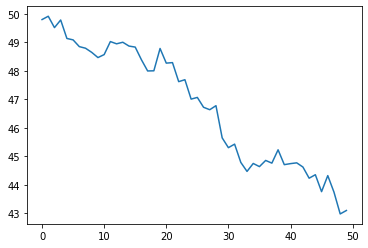

In [106]:
plt.plot(range(y.shape[0]), y[:,0])

In [107]:
betas = np.hstack((beta_i, beta_s_i))
index = np.array(range(40))
F = np.zeros((40,  5))
F[:,0] = beta_i[:40]
for j in range(4):
    F[index[yo == j],1 + j] = betas[40 + index[yo == j]]

In [9]:
betas[40 + index[yo == 0]]

array([0.29811029, 0.62524769, 0.78545736, 0.31110807, 0.2398609 ,
       0.25312692, 0.25338004, 0.77952246, 0.62975156, 0.28531228])

In [168]:
importlib.reload(sys.modules['Gibbs'])
# groups_memb = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)
w_g, v_g, beta, A, B, states, R_conds = Gibbs.lc_sector(1000, y, group_membership, calc_cond=False, regularize_S = False)

T 50, n_stock 40, n_groups 2
1 of 1000 
0.0 vs 0.0
2 of 1000 
0.0 vs 0.0
3 of 1000 
0.0 vs 0.0
4 of 1000 
0.0 vs 0.0
5 of 1000 
0.0 vs 0.0
6 of 1000 
0.0 vs 0.0
7 of 1000 
0.0 vs 0.0
8 of 1000 
0.0 vs 0.0
9 of 1000 
0.0 vs 0.0
10 of 1000 
0.0 vs 0.0
11 of 1000 
0.0 vs 0.0
12 of 1000 
0.0 vs 0.0
13 of 1000 
0.0 vs 0.0
14 of 1000 
0.0 vs 0.0
15 of 1000 
0.0 vs 0.0
16 of 1000 
0.0 vs 0.0
17 of 1000 
0.0 vs 0.0
18 of 1000 
0.0 vs 0.0
19 of 1000 
0.0 vs 0.0
20 of 1000 
0.0 vs 0.0
21 of 1000 
0.0 vs 0.0
22 of 1000 
0.0 vs 0.0
23 of 1000 
0.0 vs 0.0
24 of 1000 
0.0 vs 0.0
25 of 1000 
0.0 vs 0.0
26 of 1000 
0.0 vs 0.0
27 of 1000 
0.0 vs 0.0
28 of 1000 
0.0 vs 0.0
29 of 1000 
0.0 vs 0.0
30 of 1000 
0.0 vs 0.0
31 of 1000 
0.0 vs 0.0
32 of 1000 
0.0 vs 0.0
33 of 1000 
0.0 vs 0.0
34 of 1000 
0.0 vs 0.0
35 of 1000 
0.0 vs 0.0
36 of 1000 
0.0 vs 0.0
37 of 1000 
0.0 vs 0.0
38 of 1000 
0.0 vs 0.0
39 of 1000 
0.0 vs 0.0
40 of 1000 
0.0 vs 0.0
41 of 1000 
0.0 vs 0.0
42 of 1000 
0.0 vs 0.0
43 of 1000 
0.

a_x = 54.78493091040634, beta_i = 0.19306765580876617, v = 0.06721173871937369, w = 0.3, eta = -0.15


Text(0.5, 1.0, 'variance_x, x= 0')

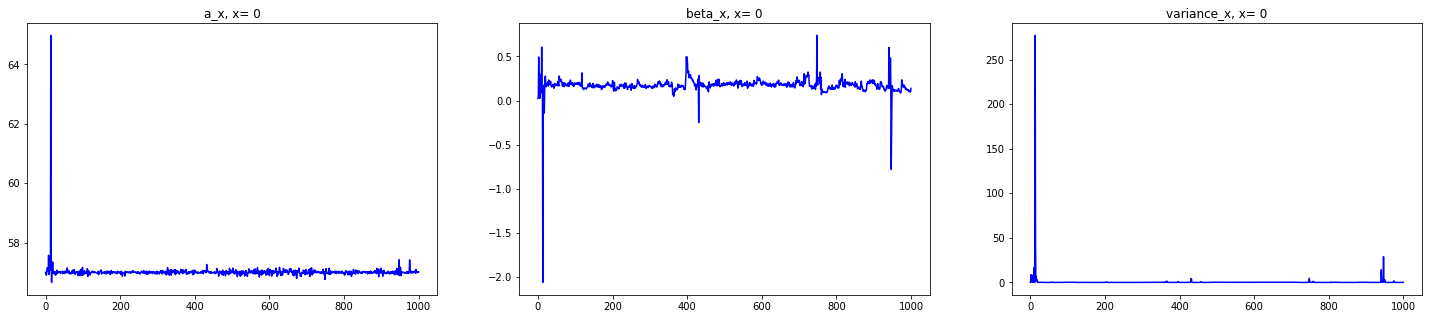

In [136]:
index = 0
print(f'a_x = {a_x[index]}, beta_i = {beta_i[index]}, v = {v[index]}, w = {w[0]}, eta = {eta[0]}')

fig, ax = plt.subplots(1,3, figsize = (25,5))
ax[0].plot(range(A.shape[0]),A[:,index], color='b')
ax[0].set_title(f'a_x, x= {index}')
ax[1].plot(range(A.shape[0]),beta[:,index], color='b')
ax[1].set_title(f'beta_x, x= {index}')
ax[2].plot(range(A.shape[0]),v_g[:,index], color='b')
ax[2].set_title(f'variance_x, x= {index}')
#ax[2].set_ylim(ymax = 0.15)


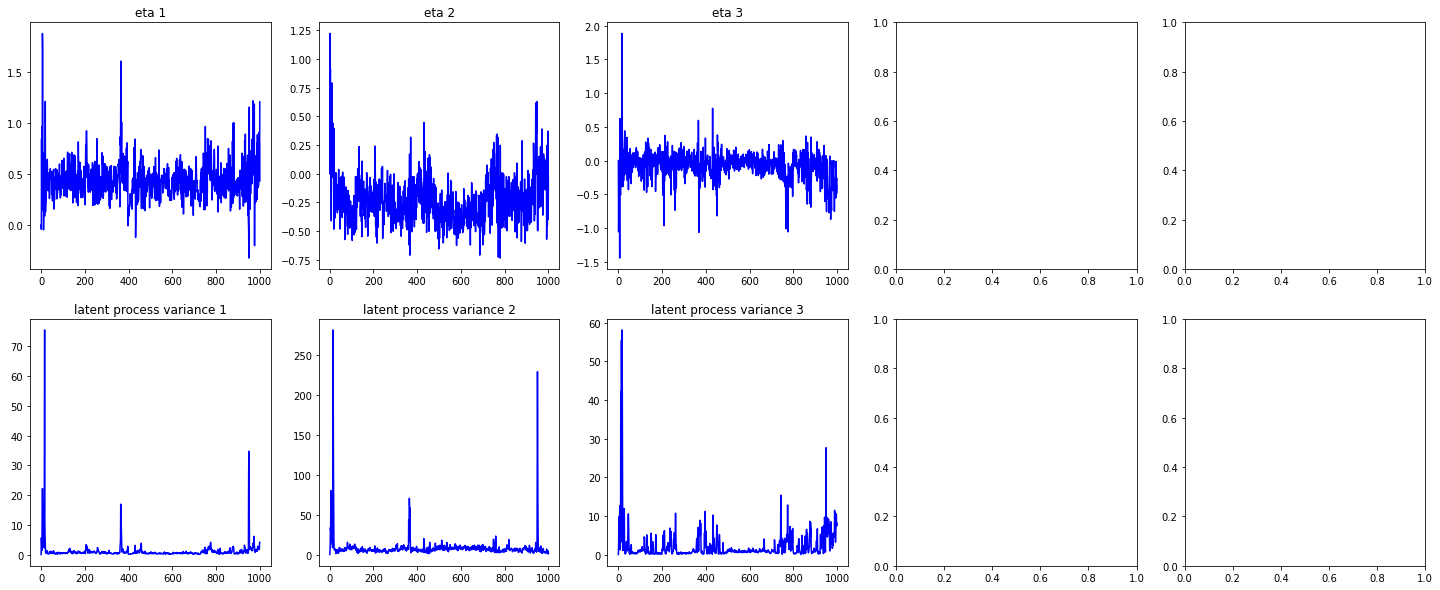

In [137]:
fig, ax = plt.subplots(2,5, figsize = (25,10))
for j in range(3):

        ax[0,j].plot(range(A.shape[0]),B[:,j], color='b')
        ax[0,j].set_title(f'eta {j+1}')
        ax[1,j].plot(range(A.shape[0]),w_g[:,j], color='b')
        ax[1,j].set_title(f'latent process variance {j+1}')


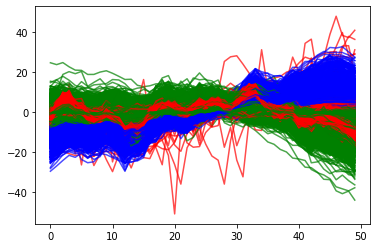

In [132]:
for i in range(states.shape[0]):
    plt.plot(range(states.shape[1]), states[i, :, 0], color = 'blue', alpha =0.7)
    plt.plot(range(states.shape[1]), states[i, :, 1], color = 'red', alpha =0.7)
    plt.plot(range(states.shape[1]), states[i, :, 2], color = 'green', alpha =0.7)

# Covariance test

In [205]:
importlib.reload(sys.modules['Gibbs'])
y = np.array(data_median_shift)
y = np.delete(y, 260, axis= 1)

In [50]:
cov = [[290, 30, 40, 70], 
        [30, 190, 90, 80],
        [40, 90, 210, 85],
        [70, 80, 85, 220]]
mean = [30, 15, 20, 25]
N = 2000


x = np.random.multivariate_normal(mean, cov, N)

In [51]:
# create missing values
for i in range(len(mean)):
    missing = np.random.choice(range(N), size = 50, replace = False)
    x[missing,i] = np.nan

In [52]:
importlib.reload(sys.modules['Gibbs'])
Sigma, mu = Gibbs.em_cov_missing_data(x, 10, Sigma = 100*np.identity(len(mean)), mu = np.ones(len(mean)))

0
1
2
3
4
5
6
7
8
9


In [53]:
print(cov)
print(Sigma)

[[290, 30, 40, 70], [30, 190, 90, 80], [40, 90, 210, 85], [70, 80, 85, 220]]
[[288.57575784  23.83969868  39.67818267  72.23460694]
 [ 23.83969868 182.87329943  91.54543749  81.05017829]
 [ 39.67818267  91.54543749 221.60319851  87.29424099]
 [ 72.23460694  81.05017829  87.29424099 219.32178391]]


In [54]:
print(mu)
print(mean)

[30.8798114  14.97390972 20.17270966 25.10428636]
[30, 15, 20, 25]


In [55]:
pd.DataFrame(x).cov()

,0,1,2,3
0,288.678473,23.415245,38.149900,72.333880
1,23.415245,183.083798,91.247467,81.356818
2,38.149900,91.247467,220.905780,85.404501
3,72.333880,81.356818,85.404501,219.576407


In [225]:
np.all(np.linalg.eigvals(Sigma) > 0)

False